In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



### Übergeordnete Fragestellung: 
> Welche technisch – ökonomischen Parametergrenzwerte sind im Kontext des Energieträgerwandels (Fossil-zu-Wasserstoff) für einen Um- oder Zubau einer saisonalen Speicher- und Versorgungsanlage in Eigenheimen und am Beispiel eines Einfamilienhauses mit Gasheizung oder einem erneuerbaren Energiesystem in Wesseling für einen Betrachtungszeitraum von 20 Jahren relevant, um eine Investition in ein saisonales Wasserstoffsystem zu bewerten?

# Auswertungs- und Grafische Darstellungsfunktionen
Grundfunktionen der nachfolgenden Funktionen. Für eine Detailbeschreibung der Argumente und Returns, kann der Docstring eingesehen werden

##### opt_series_summary()
Funktion fasst wahlweise eines Netzwerkpaares (Referenz und H2) für den Typ Gas oder EE, oder aller 4 Netzwerke die time series Daten der Optimierungsergebnisse in eine Übersicht zusammen.

##### plot_series_data()
Funktion stellt die time series der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### plot_opt_data()
Funktion stellt die p_nom_opt der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### result_summary_single_network()
Funktion fasst alle Ergebnisse Netzwerk-Ergebnisse und Berechneten Ergebnisse in einen Datensatz aus 3 DataFrames in einem Tuple zusammen

##### cost_reduction_calculation()
Funktion ermittelt ein Learning Curve Modell Datensatz zur Kostenreduktion von Wasserstoffsystemen auf Basis von Studien zur Kostenanalyse von Elektrolyseuren. Ergebnis sind drei Kostenreduktionsszenarien mit unterschiedlich starker Reduktion der Kapitalkosten für ein Wasserstoffsystem.

##### extract_specific_data()
Funktion extrahiert aus erzeugten Datensätzen einer Parametervariation alle Daten zu einem spezifischen Parameter.

##### start_capital_cost()
Funktion ermittelt für einen spezifischen Startwert die Kapitalkostenanteile der H2-Systemkomponenten.

##### compare_paypack_period()
Funktion vergleicht die Amortisationszeiten eines Wasserstoffnetzwerkes mit der Amortisationszeit des zugehörigen Referenz-Netzwerkes und berechnet eine korrigierte Amortisationszeit des Wasserstoffnetzwerkes im Fall eines zeitlich späteren Zubaus des Wasserstoff-Systems zu bestehenden Referenzkomponenten.

##### create_multi_index()
Funktion erzeugt einen Multi-Index anhand eines definierten Betrachtungszeitraumes.

##### reindex_data()
Funktion reindexiert einen Datensatz für einen neuen Betrachtungszeitraum.

In [2]:
def opt_series_summary(network, h2=False, h2_gas=False, ref_gas=False, ref=False, MI_series_summary=False):
    """
        This function sums up all optimized time series data for each component of the given network.

        Parameters:
            network (PyPSA.Network()): The Network for that a summary of the time_series data is requested
            h2, h2_gas, ref_gas, ref (bool, 1 required): Bool choice variable for decision about the passed network 
                                                         for a correct output of summarized data according to different
                                                         network components
            MI_series_summary (bool, optional): A Flag that controlls the chosen index for parameter summary 

        Returns:
            df_res_series (DataFrame): DataFrame with network specific time series data
    """
    # create index according to the networks periods
    if MI_series_summary == True:           
        date_index = create_multi_index(multi_years, freq)
    else: 
        date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
    
    
    # network choice
    if h2 == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), 
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), 
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                    index=date_index, columns=['WP']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), 
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                        index=date_index, columns=['Grid']),
                                           pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                        index=date_index, columns=['PV']),
                                           pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                        index=date_index, columns=['Einspeisung']),
                                           pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                        index=date_index, columns=['WP']),
                                           pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                        index=date_index, columns=['Electric Load']),
                                           pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                        index=date_index, columns=['Heat load']),
                                           pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                        index=date_index, columns=['WW load']),
                                           pd.DataFrame(data=(network.stores_t.e.h2_storage
                                                              + network.stores_t.e.h2_storage_1
                                                              + network.stores_t.e.h2_storage_2).to_numpy(),
                                                        index=date_index, columns=['H2 Storage']),
                                           pd.DataFrame(data=(network.links_t.p0.fc 
                                                              + network.links_t.p0.fc_1 
                                                              + network.links_t.p0.fc_2).to_numpy(), 
                                                        index=date_index, columns=['Fuel Cell']),
                                           pd.DataFrame(data=(network.links_t.p0.ely
                                                              + network.links_t.p0.ely_1 
                                                              + network.links_t.p0.ely_2).to_numpy(),
                                                        index=date_index, columns=['Electrolysis']),
                                           pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery OUT']),
                                           pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore OUT']),
                                           pd.DataFrame(data=(network.stores_t.e.battery 
                                                              + network.stores_t.e.battery_1 
                                                              + network.stores_t.e.battery_2).to_numpy(),
                                                        index=date_index, columns=['Battery']),
                                           pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                        index=date_index, columns=['Heat Storage'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                            index=date_index, columns=['Grid']),
                                               pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                            index=date_index, columns=['PV']),
                                               pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                            index=date_index, columns=['Einspeisung']),
                                               pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                            index=date_index, columns=['WP']),
                                               pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                            index=date_index, columns=['Electric Load']),
                                               pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                            index=date_index, columns=['Heat load']),
                                               pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                            index=date_index, columns=['WW load']),
                                               pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                                  + network.stores_t.e.h2_storage_1).to_numpy(),
                                                            index=date_index, columns=['H2 Storage']),
                                               pd.DataFrame(data=(network.links_t.p0.fc 
                                                                  + network.links_t.p0.fc_1).to_numpy(),
                                                            index=date_index, columns=['Fuel Cell']),
                                               pd.DataFrame(data=(network.links_t.p0.ely
                                                                  + network.links_t.p0.ely_1).to_numpy(),
                                                            index=date_index, columns=['Electrolysis']),
                                               pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery OUT']),
                                               pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore OUT']),
                                               pd.DataFrame(data=(network.stores_t.e.battery 
                                                                  + network.stores_t.e.battery_1).to_numpy(),
                                                            index=date_index, columns=['Battery']),
                                               pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                            index=date_index, columns=['Heat Storage'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                                index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), 
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), 
                                                                index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage'])], axis=1)
    
    elif h2_gas == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                                index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                                index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                                index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(),
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(),
                                                                index=date_index, columns=['Electrolysis'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis'])], axis=1)
    
    elif ref_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), 
                                                index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    elif ref == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), 
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    else:
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
            
    
    return df_res_series

In [3]:
def plot_series_data(df_series_t, MI_plot_series=False):
    """
    This function generates plots to visualize time series data from the provided
    DataFrame `df_series_t`. Each column in the DataFrame represents a different
    time series alle time series are plotted in an overview in 5:4 or 4:4 Matrix.

    Parameters:
        df_series_t (pandas.DataFrame): The DataFrame containing time series data of each networks components.
        multiinvest (bool, optional): A Flag with the decicion on the x_axes format and the time period 
        of the plot summary. Default is False.

    Returns:
        None
    """
    # generate color cycle
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # if more than 16 datasets -> add new row in plot
    if df_series_t.shape[1] > 16:
        rows = 5
    else:
        rows = 4
        
    # plot data
    fig, axes = plt.subplots(rows, 4, figsize=(16, 10))
    for col, ax in zip(df_series_t.columns, axes.flatten()):
        c = next(colors)["color"]
        if MI_plot_series == True:
            ax.plot(df_series_t.reset_index().index, df_series_t[col], color=c)
            ax.set_xticks(np.linspace(0, df_series_t.shape[0], len(multi_years)), labels=multi_years)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
        else:
            ax.plot(df_series_t.index, df_series_t[col], color=c)
            ax.set_xticks([])
            ax.set_xlabel("hours per year")
        ax.set_title(col)
        
        plt.subplots_adjust(wspace=.3, hspace=.65) 

In [4]:
def plot_opt_data(df_opt):
    """
    Plot overview of network optimization values for power and capacity.
    This function generates a plot to visualize the optimization values for power
    and capacity from the provided DataFrame.

    Parameters:
        df_opt (pandas.DataFrame): The DataFrame contains all optimized values (p_nom_opt;e_nom_opt).

    Returns:
        None
    """
    def get_cmap(n, name='hsv'):
        '''random color generator - SPEKTRUM'''
        return plt.cm.get_cmap(name, n)
    
    # if more than 2 dataset columns -> add new row in plot, if only 1 dataset just 1 plot
    if df_opt.shape[1] == 2:
        rows = 1
        cols = 2
        size_w = 14
        size_h = 8
    elif df_opt.shape[1] == 1:
        rows = 1
        cols = 1
        size_w = 14
        size_h = 6
    else:
        rows = 2
        cols = 2
        size_w = 14
        size_h = 8
    
    # reform the h2_storage value by /100 and rename the indicator
    if 'h2_storage' in df_opt.index:
        df_opt.loc['h2_storage'] = df_opt.loc['h2_storage'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage': 'h2_store*100'})
    if 'h2_storage_1' in df_opt.index:
        df_opt.loc['h2_storage_1'] = df_opt.loc['h2_storage_1'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_1': 'h2_store_1*100'})
    if 'h2_storage_2' in df_opt.index:
        df_opt.loc['h2_storage_2'] = df_opt.loc['h2_storage_2'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_2': 'h2_store_2*100'})
    if 'h2_storage_3' in df_opt.index:
        df_opt.loc['h2_storage_3'] = df_opt.loc['h2_storage_3'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_3': 'h2_store_3*100'})
    
    # generate colors
    N = 40
    cmap = get_cmap(N)
    
    # plot data
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(size_w, size_h), squeeze=False)
    for col, ax in zip(df_opt.columns, axes.flatten()):
        colors = [cmap(i) for i in range(0, 40, 2)]
        ax.bar(df_opt.index, df_opt[col], color=colors)
        ax.set_title(col)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylim(ymin=0, ymax=30)
        plt.subplots_adjust(wspace=.2, hspace=.7)

In [5]:
def result_summary_single_network(n, h2=False, h2_gas=False, ref_gas=False, ref=False, sensitivity_variable=None,
                                  plots=False, MI_analyse_network=False):
    '''METHODS DOCSTRING
        This Methods gives a summary for a network passed as argument->(n)
        By setting the choice variable it generates datasets explicit for the given network
        Data shown by the function:
            1. Summarized energies and percentages for Grid(Electric/Gas) and Self Sufficiency Rate
            2. All p_nom_opt and e_nom_opt Values of the network
            3. Additional Plot Grafik for optimized values
            4. Time Series overview of all components as Plot Matrix
            5. Sensitivity evaluation when sensitivity variable != 0

        Returns: 
        If sensitivity variable = 0 return datasets -> print results and plots directly with argument ->(plots=True)
        pandas.DataFrame: series_data (summary of time series data)
        pandas.DataFrame: df_n_opt (Networks optimized values)    
        pandas.DataFrame: analysis data (Sums of components and percentages like Self Sufficiency)
            
            use: df1, df2, df3 = analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True)
        otherwise:
        pandas.DataFrame: df_sensitivity_results (Sensitivity DataFrame as output)
            use: df1 = df1.append(analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True, sensitivity_variable))
    '''
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    
    # calculate multi_factor for calculation of analysis values 
    # for results on yearly basis
    if MI_analyse_network == True:
        multi_factor = freq / support_year_amount
    else:
        multi_factor = 1.0
        
    # co2, capex, total_loads, pv_yield, pv_used calculation (equal for all networks)
    co2_val = (n.generators_t.p.sum() * multi_factor / n.generators.efficiency *
               pd.merge(n.carriers, n.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    capex = ((n.stores.e_nom_opt * n.stores.capital_cost).sum() 
             + (n.generators.p_nom_opt * n.generators.capital_cost).sum() 
             + (n.links.p_nom_opt * n.links.capital_cost).sum())
    total_load = ((n.loads_t.p_set.electric_load.sum() + n.loads_t.p_set.heat_load.sum() 
                   + n.loads_t.p_set.ww_load.sum()) * multi_factor)
    pv_yield = n.generators_t.p.pv.sum() * multi_factor
    pv_used = n.generators_t.p.pv.sum() * multi_factor - n.generators_t.p.infeed.sum() * multi_factor
    
    # network choice
    if h2 == True:
        
        # decide about multiinvest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2=True)
            
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=['H2 EE optimized'])], axis=0)
        
        # summary of analytic value sums
        # side calculation
        
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
                    
        opex = (n.generators_t.p.grid.sum() * multi_factor * electricity_rate)
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))
        
        self_sufficiency = (((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100)
                            

        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)

        
    elif h2_gas == True:
        
        # decide about multi_invest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2),
                                           index=n.generators.p_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["H2 Gas optimized"])], axis=0)
        
        # summary of analytic value sums
        # side calculations
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
        
        
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
        
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))             
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
        
        
    elif ref_gas == True:
        
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref Gas optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
                                          
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))    
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0,
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    elif ref == True:
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref EE optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
        rev_save = ((n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate))

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save)) 
        
        self_sufficiency = ((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0, 
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    else:
        # if no choice variable set -> 
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
    
        
    # decide for return values and output
    if sensitivity_variable != None:
        # generate sensitivity results
        df_sensitivity_results = pd.concat([pd.DataFrame(data=df_analysis.loc['CO2-Emission [kg/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['CO2-Emission [kg/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV generated [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['PV generated [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['PV used [kWh/a]']),                                            
                                            pd.DataFrame(data=df_analysis.loc['PV own consumption ratio [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['PV own consumption ratio [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Amount Infeed [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Amount Infeed [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Load Total [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Load Total [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid electric [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Grid electric [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid gas [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Grid gas [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio electric [%]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Ratio electric [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio gas [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Ratio gas [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Battery stored [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Battery stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat Storage stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Heat Storage stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['converted to H2 [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['converted to H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 used [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat from H2 [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Heat from H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Self Sufficiency [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Self Sufficiency [%]']),
                                            pd.DataFrame(data=df_analysis.loc['CAPEX [€]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['CAPEX [€]']),
                                            pd.DataFrame(data=df_analysis.loc['OPEX [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['OPEX [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Infeed [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Infeed [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Savings [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Savings [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Payback Period [a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Payback Period [a]'])], axis=1)
    
        return df_sensitivity_results
    else:
        if plots == True:
            print("\nNetwork analytics: \n", df_analysis, "\n\nOptimized p_nom and e_nom and equivalent plot: \n", df_n_opt)
            plot_opt_data(df_n_opt)
            if MI_analyse_network == True:
                plot_series_data(series_data, MI_plot_series=True)
            else:
                plot_series_data(series_data)
            return (series_data, df_n_opt, df_analysis)
        else:
            return (series_data, df_n_opt, df_analysis)

In [23]:
def cost_reduction_calculation(initial_cost):
    """
    Calculate cost reduction scenarios for a hydrogen components over time (2020 - 2050).
    This function calculates cost reduction scenarios for a component over a specified time range,
    based on initial_cost, production quantities, and price data for three time points (2020 and 2030, 2050).
    It considers three price scenarios and estimates cost reductions accordingly by building learning curve model.

    Parameters:
        initial_cost (float): Component cost before price reduction.

    Returns:
        pandas.DataFrame: A DataFrame containing cost reduction scenarios over the specified time range.

    References:
        - Price and Quantity Data Source: 
          https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
          https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
        - Learning Curve Information:
          https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    """
    # Values Cost and Quantity (estimated by graphic): https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
    # mean value after calculation 4 datasets für assumption of the learning_rate or cost_reduction assumption
    Qt_2020 = 4 #GW
    Qt_2030 = 6100 #GW
    prices_2020 = [980, 720, 380, 290] #€/kW
    prices_2030 = [740, 500, 330, 220] #€/kW

    df_costred = pd.DataFrame(data={'year': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
                                     'Qts' : [4, 9, 25, 35, 55, 105, 500, 750, 1800, 3500, 6100]}) #GW

    # calculation first from base year 2020
    # determine the learning_rate, value(b) and progress_ratio for 2020 - 2030
    # dtermine the Costs in between for all 4 price scenarios
    b = [] # innovation rate
    learning_rate = [] # (1 - progress rate); percent
    progress_ratio = [] # factorial

    for i in range(4):
        b.append(np.log(prices_2030[i]/prices_2020[0])/np.log(Qt_2030/Qt_2020))
        progress_ratio.append(np.power(2, b[i]))
        learning_rate.append(1 - progress_ratio[i])

    params_dict = {'b' : b,
                  'PR': progress_ratio,
                  'LR': learning_rate}

    # cases from 2020 up -> Calculation of Ct    
    Ct_case1 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][0]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case2 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][1]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case3 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][2]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case4 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][3]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case1.append(prices_2030[0])
    Ct_case2.append(prices_2030[1])
    Ct_case3.append(prices_2030[2])
    Ct_case4.append(prices_2030[3])
    Ct_case1.insert(0, prices_2020[0])
    Ct_case2.insert(0, prices_2020[0])
    Ct_case3.insert(0, prices_2020[0])
    Ct_case4.insert(0, prices_2020[0])

    df_costred['Ct1'] = Ct_case1
    df_costred['Ct2'] = Ct_case2
    df_costred['Ct3'] = Ct_case3
    df_costred['Ct4'] = Ct_case4
    # additional value for 2050 forecast (Europe): https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
    neu1 = prices_2020[0] * np.power((50000 / Qt_2020), params_dict['b'][0])
    neu2 = prices_2020[1] * np.power((50000 / Qt_2020), params_dict['b'][1])
    neu3 = prices_2020[2] * np.power((50000 / Qt_2020), params_dict['b'][2])
    neu4 = prices_2020[3] * np.power((50000 / Qt_2020), params_dict['b'][3])
    df_costred = df_costred.append({'year': 2050, 'Qts': 50000, 'Ct1': neu1, 'Ct2': neu2, 'Ct3': neu3, 'Ct4': neu4}, ignore_index=True)

    # Typical Learning Rates are estimated by 10-20%. Learning Rates for case 2 - 4 seem to fit this estimation 
    # In logarithmic scale the curve is rather correct compared to literature: https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    df_costred['mean_Ct'] = (df_costred['Ct1'] + df_costred['Ct2'] + df_costred['Ct3'] + df_costred['Ct4']) / 4 
    df_costred['red1'] = df_costred['Ct1'] / prices_2020[0]
    df_costred['red2'] = df_costred['Ct2'] / prices_2020[0]
    df_costred['red3'] = df_costred['Ct3'] / prices_2020[0]
    df_costred['red4'] = df_costred['Ct4'] / prices_2020[0]

    #linear fitting of 2030 - 2050 (Faktoren aus Geogebra anhand der bekannten Punkte)
    def linear_cost(x, m=-2.484173, b=5542.871799):
        return m * x + b
    def linear_quant(x, m=2195, b=-4449750):
        return m * x + b
    
    
    x_vals = [i for i in range(2020, 2051, 1)]
    yq_vals = []
    y_vals = []
    for x in x_vals:
        y_vals.append(linear_cost(x))
        yq_vals.append(linear_quant(x))

    
    df_capex_reduction = pd.DataFrame()
    df_capex_reduction['year'] = x_vals
    df_capex_reduction['quantities'] = list(df_costred['Qts'][:11])+[x for x in yq_vals[-20:]]
    df_capex_reduction['capex_model1'] = list(df_costred['Ct1'][:11])+[x + 238 for x in y_vals[-20:]]
    df_capex_reduction['capex_model2'] = list(df_costred['Ct2'][:11])+list(y_vals[-20:])
    df_capex_reduction['capex_model3'] = list(df_costred['Ct3'][:11])+[x - 172 for x in y_vals[-20:]] 
    df_capex_reduction['reduced_percentage1'] = df_capex_reduction['capex_model1'] / df_capex_reduction['capex_model1'][0]
    df_capex_reduction['reduced_percentage2'] = df_capex_reduction['capex_model2'] / df_capex_reduction['capex_model2'][0]
    df_capex_reduction['reduced_percentage3'] = df_capex_reduction['capex_model3'] / df_capex_reduction['capex_model3'][0]

    df_capex_reduction.plot(x='quantities', y=['capex_model1', 'capex_model2', 'capex_model3'],
                            logx=True, logy=True, ylabel='H2-System Price [€]', 
                            color=('#cf1820', '#ec6525', '#af368c'), figsize=(9,5))
    #print(df_capex_reduction)
    #print(df_costred)
    #print(params_dict)
    
    #factor_max = 1
    #factor_std = df_capex_reduction['capex_model2'][0] / df_capex_reduction['capex_model1'][0] 
    #factor_min = df_capex_reduction['capex_model3'][0] / df_capex_reduction['capex_model1'][0] 
    #print(factor_min, factor_std)
    df_cost_reduction = pd.DataFrame()
    df_cost_reduction['year'] = x_vals
    df_cost_reduction["max"] = initial_cost * df_capex_reduction['reduced_percentage1']
    df_cost_reduction["std"] = initial_cost * df_capex_reduction['reduced_percentage2']
    df_cost_reduction["min"] = initial_cost * df_capex_reduction['reduced_percentage3']
    df_cost_reduction['[%]_1'] = df_capex_reduction['reduced_percentage1']
    df_cost_reduction['[%]_2'] = df_capex_reduction['reduced_percentage2']
    df_cost_reduction['[%]_3'] = df_capex_reduction['reduced_percentage3']
    
    return df_cost_reduction

C:\Users\Marvin\AppData\Local\Temp\ipykernel_106944\4075388216.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



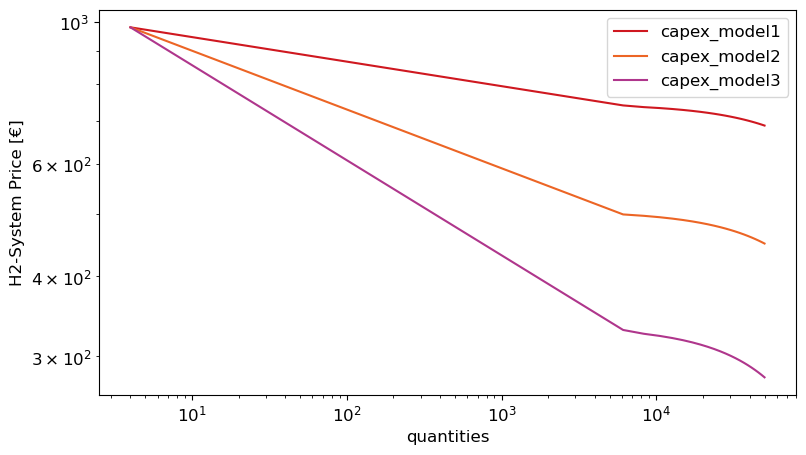

In [24]:
cost = cost_reduction_calculation(capital_cost_picea)

In [7]:
def extract_specific_data(extract_value, data, dataset_index=2):
    """
        Extract specific data based on the provided parameters.

        Parameters:
        - extract_value (str): The value to extract can be the column or index name of the specified dataset.
        - data (dict): A dictionary containing result datasets.
        - dataset_index (int, optional): The index of the dataset to extract data from.
            - 0: Concatenated time series data.
            - 1: p_nom_opt values dataset.
            - 2: DataFrame analysis dataset (default).

        Returns:
        - If dataset_index is 0, returns a DataFrame containing specific time series data.
        - If dataset_index is 1, returns a list of specific values from p_nom_opt dataset.
        - If dataset_index is 2, returns a list of specific values from df_analysis dataset.
    """
    # empty base data list for extracted values
    extracted_data = []
        
    # asked concatenated dataframe of specific times_series data over all analysed key values
    if dataset_index == 0:
        series_lst = []
        key_lst = list(data.keys())
        for i in range(len(key_lst)):
            key_lst[i] = extract_value + "_" + str(key_lst[i])
        for value in data.values():
            series_lst.append(value[0][extract_value])
        df_filter = pd.concat(series_lst, ignore_index=True, axis=1)
        range_index = [i for i in range(df_filter.shape[0])]
        df_filter.columns = key_lst
        df_filter.index = range_index
        return df_filter
    
    # asked for specific value from p_nom_opt values dataset
    elif dataset_index == 1:
        try:
            for dataset in data.values():
                extracted_data.append(dataset[dataset_index].loc[extract_value, 'H2 Gas optimized'])
        except:
            for dataset in data.values():
                extracted_data.append(dataset[dataset_index].loc[extract_value, 'H2 EE optimized'])
        return extracted_data
    
    # asked for specific value from df_analysis dataset
    elif dataset_index == 2:
        for dataset in data.values():
            extracted_data.append(dataset[dataset_index].loc[extract_value, 'analytic values'])
        return extracted_data
    else:
        print("Die Funktion benötigt einen dataset_index aus folgender Auswahl: 0, 1, 2")

In [8]:
def start_capital_cost(start_cap):
    """
        Calculate the capital costs for different components based on the specified capital.
        The capital costs for each component are calculated by multiplying the specified capital
        with the corresponding specific capital share obtained from the 'specific_cap_share' dictionary

        Parameters:
            start_cap (float): The initial capital to be allocated.

        Returns:
            list: A list containing the capital costs for hydrogen storage (start_cap_h2_storage),
                  electrolysis (start_cap_ely), fuel cells (start_cap_fc), and batteries (start_cap_battery).
    """
    start_cap_h2_storage = start_cap * specific_cap_share['h2_storage']
    start_cap_ely = start_cap * specific_cap_share['ely']
    start_cap_fc = start_cap * specific_cap_share['fc']
    start_cap_battery = start_cap * specific_cap_share['battery']
    cap_lst = [start_cap_h2_storage, start_cap_ely, start_cap_fc, start_cap_battery]
    return cap_lst

In [9]:
def compare_paypack_period(dataset_ref, dataset_h2, h2_installation_year=2020, ref_installation_year=2020):
    """
        Compare the payback periods of two datasets representing different scenarios.
        In case of a later installation year of hydrogen components it will recalculate a corrected payback period
        by difference of the previous revenues.

        Parameters:
            dataset_ref (pandas.DataFrame): DataFrame containing data for the reference result.
            dataset_h2 (pandas.DataFrame): DataFrame containing data for the hydrogen result.
            h2_installation_year (int, optional): The year of installation for the hydrogen scenario.
                Defaults to 2020.
            ref_installation_year (int, optional): The year of installation for the reference scenario.
                Defaults to 2020.

        Returns:
            payback_ratio (float): the ratio between hydrogen and reference payback times
            payback_period2 (float): corrected payback period of hydrogen networks results
    """   
    # observation period and support years
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    observation_period_passed = h2_installation_year - ref_installation_year
 
    df_analysis_ref = dataset_ref
    df_analysis_h2 = dataset_h2
        
    capex1 = df_analysis_ref.loc['CAPEX [€]', 'analytic values']
    opex1 = df_analysis_ref.loc['OPEX [€/a]', 'analytic values']
    rev_save1 = df_analysis_ref.loc['Revenue Savings [€/a]', 'analytic values']
    rev_infeed1 = df_analysis_ref.loc['Revenue Infeed [€/a]', 'analytic values']
    rev_total1 = rev_infeed1 + rev_save1
    payback_period1 = (capex1 + (opex1 * observation_period))/-(rev_total1)
    print(payback_period1)

    rev_infeed2 = df_analysis_h2.loc['Revenue Infeed [€/a]', 'analytic values']
    rev_save2 = df_analysis_h2.loc['Revenue Savings [€/a]', 'analytic values']
    rev_total1_until_h2_installation = (rev_total1 * observation_period_passed)
    rev_total2 = rev_infeed2 + rev_save2
    capex2 = df_analysis_h2.loc['CAPEX [€]', 'analytic values']
    opex2 = df_analysis_h2.loc['OPEX [€/a]', 'analytic values']

    payback_period2 = np.round(((capex2 + opex2 * (observation_period - observation_period_passed)
                                 + rev_total1_until_h2_installation)
                                /-(rev_total2)), 2)
    print(payback_period2)
    payback_ratio = payback_period2 / payback_period1
    print("\n Current Payback_ratio: ", payback_ratio)

    return payback_ratio, payback_period2

In [10]:
def create_multi_index(years_lst, freq):
    """
        this function creates a multi-index for pandas.Series snapshots of PyPSA.network() and for Input Data
    """
    snapshots = pd.DatetimeIndex([])
    for year in years_lst:
        period = pd.date_range(start='{}-01-01 00:00'.format(year),
                               freq='{}H'.format(str(freq)),
                               periods=8760 / float(freq),
                              )
        snapshots = snapshots.append(period)

    multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
    return multi_index

In [11]:
def reindex_data(data_xy, new_period):
    """
        this function performes a reindexing of a given pandas.DataFrame according a new observation period
    """
    multi_index = create_multi_index(new_period, freq)
    data_xy.index = multi_index
    return data_xy

# Import der Basisdaten

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

### Lastprofile Synthetisch: synPRO (Frauenhofer)
Getrennte profile für Warmwasser, Heizung und Strom jeweils für einen 4 Personen Haushalt in einem EFH

In [12]:
# data imports

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load loadprofile data
# 4 Residents EFH
el_4p = pd.read_csv('data/loads/4Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_4p = pd.read_csv('data/loads/4Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_4p = pd.read_csv('data/loads/4Pers/neighbourhood_htg.csv', comment='#', sep=';')


# fill dataframe
df_data = pd.DataFrame()
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()
df_data['ww_load_4p'] = dhw_4p['total']
df_data['e_load_4p'] = el_4p['total']
df_data['h_load_4p'] = htg_4p['total_htg']

# season operation of hydrogen system (use ely thw whole year, fc just in winter months)
df_season = pd.DataFrame()
df_season['ely'] = [1 for x in range(8760)]
df_season['fc'] = [0 if 3624 <= x <= 6552 else 1 for x in range(8760)]

In [13]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)

df_data

,pv,temp,ww_load_4p,e_load_4p,h_load_4p,wp_COP_interp
0,0.0,12.6,0.0,0.108191,1.274003,3.315
1,0.0,13.0,0.0,0.086217,1.798675,3.325
2,0.0,12.6,0.0,0.085922,2.127315,3.315
3,0.0,12.2,0.0,0.109169,2.364143,3.305
4,0.0,12.8,0.0,0.108558,2.529228,3.320
...,...,...,...,...,...,...
8755,0.0,15.1,0.0,0.545067,1.330839,3.378
8756,0.0,15.9,0.0,0.228792,1.550685,3.398
8757,0.0,15.9,0.0,0.291029,1.539984,3.398
8758,0.0,15.6,0.0,0.330328,1.495063,3.390


In [14]:
# globals for multi investment periods
multi_years = range(2023, 2044, 2)
observation_period = multi_years[-1] - multi_years[0]
max_lifetime = observation_period + 1
freq = 1

In [15]:
# reform data for multi investment periods

# Multi Year Datasets
# copy data
df_mdata = df_data.copy() # standard data
df_mseason = df_season.copy() # data p_max_pu for ely and fc

# reindex datasets
df_mdata.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')
df_mseason.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')

# rescale if frequency > 1
if freq > 1:
    df_mdata = df_mdata.resample(rule='{}H'.format(str(freq))).mean()
    df_mseason = df_mseason.resample(rule='{}H'.format(str(freq))).mean()
    

# multi period dataframe
# df_mdata_1h_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mdata_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mseason_xy = pd.concat([df_mseason]*len(multi_years), ignore_index=True)

# indexing
multi_index = create_multi_index(multi_years, freq)
df_mdata_xy.index = multi_index
df_mseason_xy.index = multi_index


#print(df_data['e_load_4p'].sum())
#print(df_mdata_3h['e_load_4p'].sum()*freq)
#print(df_mdata_4h['e_load_4p'].sum()*4)
#print(df_mdata_5h['e_load_4p'].sum()*5)
#df_mdata_xy['pv']

# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis werden in einfachen globalen Variablen gespeichert

In [16]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.071    # €/kWh
gas_price = 0.158 # €/kWh


# plot parameters
plt.rcParams.update({'font.size': 12})

# data calculations 
# weightings of h2 components from total system price
# specific cost assumptions
capital_cost_picea = 85000 # €
cap_h2_storage = 3891 # €/stück [€/bündel / (Nm³/bündel * kWh/Nm³)] https://www.linde-gas.de/shop/de/de-ig/wasserstoff-50-bündel-wasserstoff-50-buendel
cap_ely = 8065.25 # €/kW https://h2-batarow.com/elektrolyseure/ely-8 (Durchschnitt von 2,4 und 10kW elektrolyseur)
cap_fc = 5000 # €/kW https://www.haus.de/smart-home/brennstoffzellenheizung-funktion-und-kosten-28912 (Stackkosten)
cap_battery = 1200 # €/kWh
cap_total_system = cap_h2_storage + cap_battery + cap_ely + cap_fc
specific_cap_share = {'h2_storage': cap_h2_storage / cap_total_system,
                      'battery': cap_battery / cap_total_system,
                      'ely': cap_ely / cap_total_system,
                      'fc' : cap_fc / cap_total_system} 

# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'p_max_pu_multi': df_mdata_xy['pv'],
    'capital_cost': 1750, #€/kWp
    'lifetime' : 20,
    'pv_co2': 0   #kg/kWh
}

# Picea Home System: https://www.homepowersolutions.de/produkt/
# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'p_max_pu': df_season['fc'],
    'p_max_pu_multi': df_mseason_xy['fc'],
    'el_efficiency': 0.6,
    'th_efficiency': 0.3,
    'capital_cost': (capital_cost_picea * specific_cap_share['fc'])/1.5,
    'lifetime' : 10,
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'p_max_pu': df_season['ely'],
    'p_max_pu_multi': df_mseason_xy['ely'],
    'el_efficiency': 0.7,
    'th_efficiency': 0.2,
    'capital_cost': (capital_cost_picea * specific_cap_share['ely'])/2.3,
    'lifetime' : 10,
}

# H2 gas storage
h2_storage_params = {
    'e_nom_max': 1500/fc_params['el_efficiency'], #kWh_el - picea, auf 1500 kWh_el erweiterbar
    'e_nom_min': 300/fc_params['el_efficiency'],
    'e_nom': 300/fc_params['el_efficiency'],
    'capital_cost': (capital_cost_picea * specific_cap_share['h2_storage'])/(300/fc_params['el_efficiency']), # €/kWh picea system spezifisch auf die durchschnittliche Kapazität(Mittelwert von min und max)
    'standing_loss': 0.00001,
    'lifetime' : 10,
    'h2_co2': 0   #kg/kWh
}

# battery storage
battery_picea_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 10,
    'capital_cost': (capital_cost_picea * specific_cap_share['battery'])/20,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5.7,
    'discharge_power': 5.7,
    'lifetime' : 10
}



# Standard battery: https://greencell.global/de/energie-speichern/4846-green-cell-gc-powernest-energiespeicher-lifepo4-akku-5-kwh-48-v.html#specification
battery_params = {
    'e_nom': 5,
    'e_nom_min': 2,
    'capital_cost': 2630/5,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5,
    'discharge_power': 5,
    'lifetime' : 10
}


# heatpump -> wp: https://www.viessmann.de/de/wissen/technik-und-systeme/waermepumpe.html
wp_params = {
    'p_nom': 13.2,
    'efficiency': df_data['wp_COP_interp'],
    'efficiency_multi': df_mdata_xy['wp_COP_interp'],
    'capital_cost': 20000/13.2,
    'lifetime' : 20
}

# heat storage: https://www.viessmann.de/de/produkte/warmwasserbereiter/vitocell-140-e.html
heat_storage_params = {
    'e_nom': 15, #kWh
    'e_nom_min': 5,
    'volume': 300, #Litre
    'capital_cost': 1465/15,
    'standing_loss': 0.0875,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
    'lifetime' : 20
}

# heating rod: https://www.g2-energy-systems.de/elektroheizelemente-heizkoerper/elektroheizelemente/gekapselte-keramikheizpatronen/gekapselte-keramikheizstaebe-mit-flansch-keramische-heizelemente.html
heating_rod_params = {
    'p_nom': 2.2, #kW
    'p_nom_picea': 4.5, #kW
    'efficiency': 1,
    'capital_cost': 210/2.2,
    'capital_cost_picea': 210/4.5,
    'lifetime' : 20
}

# Gas Boiler: https://www.klimaworld.com/vaillant-brennwerttherme-ecotec-plus-vcw-25-32-cs-1-5-0010043902.html?utm_source=google&utm_medium=cpc&_attribution=GoogleAds&gclid=CjwKCAjw5_GmBhBIEiwA5QSMxLOYbOb4IxBXSJmPPku7bedGxHHWe1i2163OTuT7KkkfBs4bLBmYkBoCTWcQAvD_BwE
gas_boiler_params = {
    'p_nom': 25, #kW
    'efficiency': 1.09,
    'capital_cost': 5650/25,
    'lifetime' : 20
}


#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.434, #kg/kWh (https://de.statista.com/statistik/daten/studie/38897/umfrage/co2-emissionsfaktor-fuer-den-strommix-in-deutschland-seit-1990/#:~:text=Im%20Jahr%202022%20wurde%20der,mit%20kleinen%20Ausnahmen%20kontinuierlich%20ab.)
    'co2_emissions_gas' : 0.202 #kg/kWh (https://www.verbraucherzentrale.de/wissen/energie/heizen-und-warmwasser/klimapaket-was-bedeutet-es-fuer-mieter-und-hausbesitzer-43806)
}


# load specifications globals
# loads single year apporach
eload4 = df_data['e_load_4p']
hload4 = df_data['h_load_4p']
wwload4 = df_data['ww_load_4p']

# loads multi invest period
eload4m = df_mdata_xy['e_load_4p']
hload4m = df_mdata_xy['h_load_4p']
wwload4m = df_mdata_xy['ww_load_4p']



# Referenz-Netzwerke
Die Referenz-Netzwerke dienen einerseits dem Vergleich mit der Wasserstofflösung. Andererseits können diese Dazu genutzt werden Komponenten wie Wärmepumpe oder Gas Boiler zu optimieren und diese Werte anschließend als Startpunkt für die H2-Netzwerke vorzugeben.

##### Referenz Network Gas
Das Referenz-Netzwerk Gas ist ein Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + Gas Boiler und Heizstab.

##### Referenz Network EE
Das Referenz-Netzwerk Gas ist ein Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + eine Wärmepumpe, die anstelle des Boilers und Heizstabes zur Abdeckung der gesamten Heizlast optimiert werden soll.

In [ ]:
def build_ref_network_gas(electric_load, heat_load, ww_load):
    
    """
    Build a reference network for a hybrid electricity, heat and gas system.
    This function initializes a PyPSA network and adds various components to create a model
    of a hybrid energy system that includes electricity, heat, and gas components. 
    It sets up a complete model with specific parameters for each component in order to represent
    a partly renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing a reference gas network.  
    """
    
    # initialyze network
    n_gas = pypsa.Network()
    n_gas.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_gas.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_gas.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_gas.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_gas.add('Bus', name='electricity')
    n_gas.add('Bus', name='bat_bus')    
    # heat buses
    n_gas.add('Bus', name='heat')
    n_gas.add('Bus', name='heat_storage_bus')
    # gas bus
    n_gas.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_gas.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_gas.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_gas.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_gas.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              carrier='pv_electricity')
    # grid  
    n_gas.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_gas.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)
    # gas
    n_gas.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_gas.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'],
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_gas.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    
    n_gas.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_gas.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
              
    n_gas.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              p_nom_max = gas_boiler_params['p_nom'],
              carrier = 'gas',
              p_nom_extendable = True)
    
    n_gas.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost'],
              p_nom_extendable = True)
    
    n_gas.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    n_gas.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    
    # Global Constraints
    n_gas.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_gas

In [ ]:
def build_ref_network_ee(electric_load, heat_load, ww_load):
    """
    Build a reference network for an electricity and heat hybrid system based on renewable components.
    This function initializes a PyPSA network and adds various components to create a model 
    of a hybrid energy system that includes electricity, heat related renewable components. 
    It sets up a complete model with specific parameters for each component in order to 
    represent a fully renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing the electricity and heat hybrid system.
    """
    
    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_ref.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              carrier='pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_ref.add('Store', name='heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom_max = wp_params['p_nom'],
              p_nom_extendable = True)
    
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

# Wasserstoff-Netzwerke

##### H2 Network Gas multi analysis + default
**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

##### H2 Network EE multi analysis + default 
**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

In [ ]:
def build_h2_network_gas_m(electric_load, heat_load, ww_load, 
                           multi_invest_h2g=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                           init_build_year=multi_years[0], lifetime_h2=None):
    """
        Build a network for a hydrogen-expanded energy system from a natural gas and pv powered system.
        For single-year networks (multi_invest_h2g=False), it creates components with capital costs based on the chosen cost scenario.
        For multi-year networks (multi_invest_h2g=True), it iteratively adds components for each year in the multi_years list,
        including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
        initial build years.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.
        - multi_invest_h2g (bool, optional): Whether to create a multi-investment network (default is False).
        - cost_data (pandas.DataFrame, optional): cost reduction data if not default
        - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
        - init_build_year (int, optional): The initial year for building hydrogen components 
                                            (default is the first year in observation period).
        - lifetime_h2 (int:float): to specify the lifetime of h2 components in scenarios 
                                    where the lifetime is not default.

        Returns:
            pypsa.Network: A PyPSA network object representing the hydrogen-expanded and natural gas energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2g, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year, 
          "\nLifetime H2 (None=default): ", lifetime_h2)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    # define cost data
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
        
    
    # build and return multi-investment period Network
    if multi_invest_h2g == True:
        # initialyze network
        n_h2gm = pypsa.Network(override_component_attrs=override_component_attrs)
        multi_index = create_multi_index(multi_years, freq)
        
        n_h2gm.snapshots = multi_index
        n_h2gm.investment_periods = multi_years
        
        # set lifetime if lifetime_h2 parameter is set
        if lifetime_h2 == None:
            lifetime_bat_picea = battery_picea_params['lifetime']
            lifetime_h2_storage = h2_storage_params['lifetime']
            lifetime_ely = ely_params['lifetime']
            lifetime_fc = fc_params['lifetime']
        else:
            lifetime_bat_picea = lifetime_h2_storage = lifetime_ely = lifetime_fc = lifetime_h2
            
        # add components
        # Carrier
        n_h2gm.add('Carrier', name = 'grid_electricity', 
                   co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2gm.add('Carrier', name = 'pv_electricity', 
                   co2_emissions = pv_params['pv_co2'])
        n_h2gm.add('Carrier', name = 'gas',
                   co2_emissions = co2_params['co2_emissions_gas'])
        n_h2gm.add('Carrier', name = 'h2', 
                   co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2gm.add('Bus', name='electricity')
        n_h2gm.add('Bus', name='bat_bus')    
        # heat buses
        n_h2gm.add('Bus', name='heat')
        n_h2gm.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2gm.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2gm.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2gm.add('Load', name='electric_load', bus='electricity',
                   p_set = electric_load)
        # heat
        n_h2gm.add('Load', name='heat_load', bus='heat', 
                   p_set = heat_load)
        # warm water
        n_h2gm.add('Load', name='ww_load', bus='heat_storage_bus', 
                   p_set = ww_load)

        # Generators
        # PV
        n_h2gm.add('Generator', name='pv', bus='electricity',
                   p_nom = pv_params['p_nom'],
                   p_max_pu = pv_params['p_max_pu_multi'],
                   capital_cost = pv_params['capital_cost'],
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   carrier='pv_electricity')
        # Grid
        n_h2gm.add('Generator', name='infeed', bus='electricity',
                   marginal_cost = infeed_rate,
                   sign = -1,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True)
        
        n_h2gm.add('Generator', name='grid', bus='electricity',
                   marginal_cost = electricity_rate,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'grid_electricity')
        # Gas Grid
        n_h2gm.add('Generator', name='gas', bus='gas_bus',
                   marginal_cost = gas_price,
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'gas')
        

        # Storages
        n_h2gm.add('Store', name='battery', bus='bat_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                   standing_loss = battery_picea_params['standing_loss'],
                   build_year = init_build_year,
                   lifetime = lifetime_bat_picea,
                   e_nom = battery_picea_params['e_nom'],
                   e_nom_extendable = False,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='heat_storage', bus='heat_storage_bus',
                   capital_cost = heat_storage_params['capital_cost'],
                   standing_loss = heat_storage_params['standing_loss'],
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   e_nom_min = heat_storage_params['e_nom_min'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='h2_storage', bus='h2_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                   standing_loss = h2_storage_params['standing_loss'], 
                   build_year = init_build_year,
                   lifetime = lifetime_h2_storage,
                   e_nom_min = h2_storage_params['e_nom_min'],
                   e_nom_max = h2_storage_params['e_nom_max'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)

        # Storage component replacement
        if lifetime_h2 == None:
            rep_battery = replace_component(battery_picea_params['lifetime'])
            rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        else:
            rep_battery = replace_component(lifetime_h2)
            rep_h2_storage = replace_component(lifetime_h2)
        print("Battery_replacement years: ", rep_battery,"\nH2 Storage_replacement years: ", rep_h2_storage)
        
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2gm.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                           /battery_picea_params['e_nom']),
                           standing_loss = battery_picea_params['standing_loss'],
                           lifetime = lifetime_bat_picea,
                           e_nom = battery_picea_params['e_nom'],
                           e_nom_max = battery_picea_params['e_nom'],
                           e_nom_extendable = True,
                           build_year = year,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2gm.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                           /h2_storage_params['e_nom_min']),
                           standing_loss = h2_storage_params['standing_loss'],
                           e_nom = h2_storage_params['e_nom'],
                           e_nom_max = h2_storage_params['e_nom_max'],
                           build_year = year,
                           lifetime = lifetime_h2_storage,
                           e_nom_extendable = True,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        # Links
        # Boiler and Heating Rod
        n_h2gm.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                   efficiency = heating_rod_params['efficiency'],
                   capital_cost = heating_rod_params['capital_cost_picea'],
                   p_nom_max = heating_rod_params['p_nom_picea'], 
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True)

        n_h2gm.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                   efficiency = gas_boiler_params['efficiency'],
                   capital_cost = gas_boiler_params['capital_cost'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   carrier = 'gas',
                   p_nom_max = gas_boiler_params['p_nom'],
                   p_nom_extendable = True)

        # Charge and Discharge
        n_h2gm.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                   p_nom = battery_picea_params['charge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['charge_efficiency'])
        n_h2gm.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                   p_nom = battery_picea_params['discharge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['discharge_efficiency'])
        n_h2gm.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                   efficiency = heat_storage_params['charge_efficiency'],
                   p_nom_extendable=True,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_max = gas_boiler_params['p_nom'])
        n_h2gm.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                   efficiency = heat_storage_params['discharge_efficiency'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable=True,
                   p_nom_max = gas_boiler_params['p_nom'])
        

        # Multilinks
        # electrolysis
        n_h2gm.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                   efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']), 
                   build_year = init_build_year,
                   lifetime = lifetime_ely,
                   p_nom_min = ely_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = ely_params['p_max_pu_multi'],
                   carrier='h2')
        # fuel cell
        n_h2gm.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                   efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                   lifetime = lifetime_fc,
                   build_year = init_build_year,
                   p_nom_min = fc_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = fc_params['p_max_pu_multi'],
                   carrier='h2')

        # Multilink component replacement
        if lifetime_h2 == None:
            rep_ely = replace_component(ely_params['lifetime'])
            rep_fc = replace_component(fc_params['lifetime'])
        else:
            rep_ely = replace_component(lifetime_h2)
            rep_fc = replace_component(lifetime_h2)
        print("Electrolyser replacement years: ", rep_ely,"\nFuel Cell replacement years: ", rep_fc)
        
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2gm.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat',
                           efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                           /ely_params['p_nom']),
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = ely_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = lifetime_ely,
                           carrier='h2')
        # fuel cell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2gm.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                           efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                           /fc_params['p_nom']),
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = fc_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = lifetime_fc,
                           carrier='h2')


        # Global Constraints
        n_h2gm.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                   carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2gm
        
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)   
    elif multi_invest_h2g == False:
    
        # initialyze network
        n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
        #n_h2 = pypsa.Network()
        n_h2g.set_snapshots(range(8760))

        # add components

        # Carrier
        n_h2g.add('Carrier', name = 'grid_electricity', 
                  co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2g.add('Carrier', name = 'pv_electricity', 
                  co2_emissions = pv_params['pv_co2'])
        n_h2g.add('Carrier', name = 'gas',
                  co2_emissions = co2_params['co2_emissions_gas'])
        n_h2g.add('Carrier', name = 'h2', 
                  co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2g.add('Bus', name='electricity')
        n_h2g.add('Bus', name='bat_bus')    
        # heat buses
        n_h2g.add('Bus', name='heat')
        n_h2g.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2g.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2g.add('Load', name='electric_load', bus='electricity',
                  p_set = electric_load)
        # heat
        n_h2g.add('Load', name='heat_load', bus='heat', 
                  p_set = heat_load)
        # warm water
        n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
                  p_set = ww_load)

        # Generators
        n_h2g.add('Generator', name='pv', bus='electricity',
                 p_set = pv_params['p_nom'] * pv_params['p_max_pu'],
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 carrier='pv_electricity')
        # grid
        n_h2g.add('Generator', name='infeed', bus='electricity',
                  marginal_cost = infeed_rate,
                  sign = -1, 
                  p_nom_extendable = True)
        n_h2g.add('Generator', name='grid', bus='electricity',
                  marginal_cost = electricity_rate,
                  p_nom_extendable = True,
                  carrier = 'grid_electricity')
        # gas grid
        n_h2g.add('Generator', name='gas', bus='gas_bus',
                  marginal_cost = gas_price,
                  carrier = 'gas',
                  p_nom_extendable = True)

        # Storages
        n_h2g.add('Store', name='battery', bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  standing_loss = battery_picea_params['standing_loss'],
                  e_nom = battery_picea_params['e_nom'],
                  e_nom_max = battery_picea_params['e_nom'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  standing_loss = heat_storage_params['standing_loss'], 
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom = h2_storage_params['e_nom'],
                  e_nom_max = h2_storage_params['e_nom_max'],
                  e_nom_extendable = True,
                  e_cyclic = True)


        # Links
        n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                  p_nom = battery_picea_params['charge_power'],
                  efficiency = battery_picea_params['charge_efficiency'])
        n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                  p_nom = battery_picea_params['discharge_power'],
                  efficiency = battery_picea_params['discharge_efficiency'])

        n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                  efficiency = heating_rod_params['efficiency'],
                  capital_cost = heating_rod_params['capital_cost_picea'],
                  p_nom_max = heating_rod_params['p_nom_picea'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                  efficiency = gas_boiler_params['efficiency'],
                  capital_cost = gas_boiler_params['capital_cost'],
                  carrier = 'gas',
                  p_nom_max = gas_boiler_params['p_nom'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                  efficiency = heat_storage_params['charge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])
        n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                  efficiency = heat_storage_params['discharge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])


        # Multilinks
        # electrolysis
        n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']),
                  p_nom = ely_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = ely_params['p_max_pu'],
                  carrier='h2')
        # fuel cell
        n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                  p_nom = fc_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = fc_params['p_max_pu'],
                  carrier='h2')

        # Global Constraints
        n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
                  carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2g

In [ ]:
def build_h2_network_ee_m(electric_load, heat_load, ww_load,
                          multi_invest_h2=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                          init_build_year=multi_years[0], lifetime_h2=None):
    """
        Build a network for a hydrogen-expanded energy system from a renewable powered system with pv, battery and heat pump.
        For single-year networks (multi_invest_h2=False), it creates components with capital costs based on the chosen cost scenario.
        For multi-year networks (multi_invest_h2=True), it iteratively adds components for each year in the multi_years list,
        including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
        initial build years.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.
        - multi_invest_h2 (bool, optional): Whether to create a multi-investment network (default is False).
        - cost_data (pandas.DataFrame, optional): cost reduction data if not default
        - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
        - init_build_year (int, optional): The initial year for building hydrogen components 
                                            (default is the first year in observation period).
        - lifetime_h2 (int:float): to specify the lifetime of h2 components in scenarios 
                                    where the lifetime is not default.

        Returns:
            pypsa.Network: A PyPSA network object representing the hydrogen-expanded and renewable powered energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year, 
          "\nLifetime H2 (None=default): ", lifetime_h2)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks   
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ] 
    
    # define cost data
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
    
    # build and return multi-investment period Network
    if multi_invest_h2 == True:
        # initialyze network
        n_h2m = pypsa.Network(override_component_attrs=override_component_attrs)
        multi_index = create_multi_index(multi_years, freq)
        n_h2m.snapshots = multi_index
        n_h2m.investment_periods = multi_years
        
        # set lifetime if lifetime_h2 parameter is set
        if lifetime_h2 == None:
            lifetime_bat_picea = battery_picea_params['lifetime']
            lifetime_h2_storage = h2_storage_params['lifetime']
            lifetime_ely = ely_params['lifetime']
            lifetime_fc = fc_params['lifetime']
        else:
            lifetime_bat_picea = lifetime_h2_storage = lifetime_ely = lifetime_fc = lifetime_h2
            
        # add components
        # Carrier
        n_h2m.add('Carrier', name = 'grid_electricity',
                  co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2m.add('Carrier', name = 'pv_electricity', 
                  co2_emissions = pv_params['pv_co2'])
        n_h2m.add('Carrier', name = 'h2', 
                  co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2m.add('Bus', name='electricity')
        n_h2m.add('Bus', name='bat_bus')
        # heat buses
        n_h2m.add('Bus', name='heat')
        n_h2m.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2m.add('Bus', name='h2_bus', carrier='h2_electricity')

        # Loads
        # electrical
        n_h2m.add('Load', name='electric_load', bus='electricity',
                  p_set = electric_load)
        # heat
        n_h2m.add('Load', name='heat_load', bus='heat', 
                  p_set = heat_load)
        # warm water
        n_h2m.add('Load', name='ww_load', bus='heat_storage_bus', 
                  p_set = ww_load)
        
        # Generators
        # PV
        n_h2m.add('Generator', name='pv', bus='electricity',
                  p_nom = pv_params['p_nom'],
                  p_max_pu = pv_params['p_max_pu_multi'],
                  capital_cost = pv_params['capital_cost'],
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  carrier='pv_electricity')
        # Grid  
        n_h2m.add('Generator', name='infeed', bus='electricity',
                  marginal_cost = infeed_rate,
                  sign = -1,
                  build_year = multi_years[0], 
                  lifetime = max_lifetime,
                  p_nom_extendable = True)
        n_h2m.add('Generator', name='grid', bus='electricity',
                  marginal_cost = electricity_rate,
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  p_nom_extendable = True,
                  carrier = 'grid_electricity')        
        
        # Storages
        n_h2m.add('Store', name='battery',  bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  standing_loss = battery_picea_params['standing_loss'],
                  lifetime = lifetime_bat_picea,
                  e_nom = battery_picea_params['e_nom'],
                  build_year = init_build_year,
                  e_nom_extendable = False,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  standing_loss = heat_storage_params['standing_loss'],
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                  /h2_storage_params['e_nom_min']),
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom_min = h2_storage_params['e_nom_min'],
                  e_nom_max = h2_storage_params['e_nom_max'],
                  build_year = init_build_year,
                  lifetime = lifetime_h2_storage,
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        
        # Storage component replacement
        if lifetime_h2 == None:
            rep_battery = replace_component(battery_picea_params['lifetime'])
            rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        else:
            rep_battery = replace_component(lifetime_h2)
            rep_h2_storage = replace_component(lifetime_h2)
        print("Battery replacement years: ", rep_battery,"\nH2 Storage replacement years: ", rep_h2_storage)
        
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2m.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                          /battery_picea_params['e_nom']),
                          standing_loss = battery_picea_params['standing_loss'],
                          lifetime = lifetime_bat_picea,
                          e_nom = battery_picea_params['e_nom'],
                          e_nom_max = battery_picea_params['e_nom'],
                          e_nom_extendable = True,
                          build_year = year,
                          e_cyclic = True,
                          e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2m.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                         capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                         /h2_storage_params['e_nom_min']),
                         standing_loss = h2_storage_params['standing_loss'],
                         e_nom = h2_storage_params['e_nom'],
                         e_nom_max = h2_storage_params['e_nom_max'],
                         build_year = year,
                         lifetime = lifetime_h2_storage,
                         e_nom_extendable = True,
                         e_cyclic = True,
                         e_cyclic_per_period = True)
        
        # Links
        # WP
        n_h2m.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency_multi'],
                 capital_cost = wp_params['capital_cost'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])      
        # Charge and Discharge
        n_h2m.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2m.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2m.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_max = wp_params["p_nom"])
        n_h2m.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        
        # Multilinks
        # electrolyser
        n_h2m.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                  /ely_params['p_nom']),
                  p_nom_min = ely_params['p_nom'],
                  p_max_pu = ely_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = lifetime_ely,
                  p_nom_extendable=True,
                  carrier='h2')
        # fuel cell
        n_h2m.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                  /fc_params['p_nom']),
                  p_nom_min = fc_params['p_nom'],
                  p_max_pu = fc_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = lifetime_fc,
                  p_nom_extendable=True,
                  carrier='h2')
        
        # Multilink component replacement
        if lifetime_h2 == None:
            rep_ely = replace_component(ely_params['lifetime'])
            rep_fc = replace_component(fc_params['lifetime'])
        else:
            rep_ely = replace_component(lifetime_h2)
            rep_fc = replace_component(lifetime_h2)
        print("Electrolyser replacement years: ", rep_ely,"\nFuel Cell replacement years: ", rep_fc)
        
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2m.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat', 
                          efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                          /ely_params['p_nom']),
                          p_nom = ely_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = ely_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = lifetime_ely,
                          carrier='h2')
        # fuellcell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2m.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                          efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                          /fc_params['p_nom']),
                          p_nom = fc_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = fc_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = lifetime_fc,
                          carrier='h2')
        
        
        # Global Constraints
        n_h2m.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf,)            
        
        return n_h2m
    
    
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)
    elif multi_invest_h2 == False:
        # initialyze network
        n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
        
        # set snapshots
        n_h2.set_snapshots(range(8760))
        
        # add components
        # Carrier
        n_h2.add('Carrier', name = 'grid_electricity', 
                 co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2.add('Carrier', name = 'pv_electricity', 
                 co2_emissions = pv_params['pv_co2'])
        n_h2.add('Carrier', name = 'h2', 
                 co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2.add('Bus', name='electricity')
        n_h2.add('Bus', name='bat_bus')
        # heat buses
        n_h2.add('Bus', name='heat')
        n_h2.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2.add('Bus', name='h2_bus')

        # Loads
        # electrical
        n_h2.add('Load', name='electric_load', bus='electricity',
                 p_set = electric_load)
        # heat
        n_h2.add('Load', name='heat_load', bus='heat', 
                 p_set = heat_load)
        # warm water
        n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
                 p_set = ww_load)

        # Generators
        # PV
        n_h2.add('Generator', name='pv', bus='electricity',
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 carrier='pv_electricity')
        # Grid
        n_h2.add('Generator', name='infeed', bus='electricity',
                 marginal_cost = infeed_rate,
                 sign = -1,
                 p_nom_extendable = True)

        n_h2.add('Generator', name='grid', bus='electricity', 
                 marginal_cost = electricity_rate,
                 p_nom_extendable = True,
                 carrier = 'grid_electricity')        
        
        # Storages
        n_h2.add('Store', name='battery',  bus='bat_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                 /battery_picea_params['e_nom']),
                 standing_loss = battery_picea_params['standing_loss'],
                 e_nom = battery_picea_params['e_nom'],
                 e_nom_max = battery_picea_params['e_nom'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
                 capital_cost = heat_storage_params['capital_cost'],
                 standing_loss = heat_storage_params['standing_loss'],
                 e_nom_min = heat_storage_params['e_nom_min'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name='h2_storage', bus='h2_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                 /h2_storage_params['e_nom_min']),
                 standing_loss = h2_storage_params['standing_loss'],
                 e_nom_max = h2_storage_params['e_nom_max'],
                 e_nom_extendable = True,
                 e_cyclic = True)

        # Links
        # WP
        n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency'],
                 capital_cost = wp_params['capital_cost'],
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])
        # Charge and Discharge
        n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])

        # Multilinks
        # electrolyser
        n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                 efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                 /ely_params['p_nom']),
                 p_nom = ely_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = ely_params['p_max_pu'],
                 carrier='h2')
        # fuel cell
        n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                 efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                 /fc_params['p_nom']),
                 p_nom = fc_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = fc_params['p_max_pu'],
                 carrier='h2')

        # Global Constraints
        n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2

### Setup Referenz-Netzwerke

In [ ]:
# setup reference networks and optimize
reference_gas = build_ref_network_gas(eload4, hload4, wwload4)
reference_ee = build_ref_network_ee(eload4, hload4, wwload4)
reference_gas.optimize(solver_name='gurobi')
reference_ee.optimize(solver_name='gurobi')
p_nom_opt_gas_boiler = reference_gas.links.p_nom_opt.gas_boiler
p_nom_opt_wp = reference_ee.links.p_nom_opt.wp
print("!----------------------------references set up------------------------------!")

ref_res_gas = result_summary_single_network(reference_gas, ref_gas=True, plots=True)
ref_res_ee = result_summary_single_network(reference_ee, ref=True, plots=True)
ref_gas_pp = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
ref_ee_pp = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
co2_start_ref_gas = ref_res_gas[2].loc['CO2-Emission [kg/a]', 'analytic values']
co2_start_ref_ee = ref_res_ee[2].loc['CO2-Emission [kg/a]', 'analytic values']

print("!----------------------------results summarized------------------------------!")

del reference_gas
del reference_ee

%store ref_res_gas
%store ref_res_ee
%store ref_gas_pp
%store ref_ee_pp
%store co2_start_ref_gas
%store co2_start_ref_ee
%store p_nom_opt_gas_boiler
%store p_nom_opt_wp
print("\nPayback Period EE: ", ref_ee_pp, " Jahre")
print("\nPayback Period Gas: ", ref_gas_pp, " Jahre")

# Sensitivität Netzwerkverhalten
### Prequalifizierung

**Einfluss...** 
1) H2_Speichergröße
2) Leistung des Elektrolyseurs und der Brennstoffzellen
3) Reduzierung der CO2 (Referenz)
4) Gas-Netzwerk Boiler+Heating Rod (Referenz + H2)
5) EE-Netzwerk Wärmepumpe (Referenz + H2)



In [ ]:
# 1) H2_Speichergröße (s_pq1)
# define result datasets
df_s_pq1_res_gas = pd.DataFrame()
df_s_pq1_res_ee = pd.DataFrame()

# setup networks
s_pq1_gas = build_h2_network_gas_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq1_gas.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq1_gas.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s_pq1_gas.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s_pq1_gas.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']

s_pq1_ee = build_h2_network_ee_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq1_ee.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq1_ee.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s_pq1_ee.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s_pq1_ee.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']

print("!----------------------------networks initialized------------------------------!")

s_pq1_res_gas = {}
s_pq1_res_ee = {}
# looping over h2_storage capacity
for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+1, 1000):
    print('Current Capacity: ', capacity)
    s_pq1_gas.stores.loc['h2_storage', 'e_nom'] = capacity
    s_pq1_gas.optimize(solver_name='gurobi')
    s_pq1_res_gas[capacity] = result_summary_single_network(s_pq1_gas, h2_gas=True)
    df_s_pq1_res_gas = df_s_pq1_res_gas.append(result_summary_single_network(s_pq1_gas, h2_gas=True, sensitivity_variable=capacity))
    
    s_pq1_ee.stores.loc['h2_storage', 'e_nom'] = capacity
    s_pq1_ee.optimize(solver_name='gurobi')
    s_pq1_res_ee[capacity] = result_summary_single_network(s_pq1_ee, h2=True)
    df_s_pq1_res_ee = df_s_pq1_res_ee.append(result_summary_single_network(s_pq1_ee, h2=True, sensitivity_variable=capacity))

print("!----------------------------results generated------------------------------!")



print("\n\nEE Network: H2 Storage Capacity 500 kWh vs. 2500 kWh")
print("\nEE Network: 500 kWh")
plot_series_data(s_pq1_res_ee[500][0])
print("\nEE Network: 2500 kWh")
plot_series_data(s_pq1_res_ee[2500][0])

print("\n\nGas Network: H2 Storage Capacity 500 kWh vs. 2500 kWh")
print("\nGas Network: 500 kWh")
plot_series_data(s_pq1_res_gas[500][0])
print("\nGas Network: 2500 kWh")
plot_series_data(s_pq1_res_gas[2500][0])

%store s_pq1_res_gas
%store s_pq1_res_ee
%store df_s_pq1_res_gas
%store df_s_pq1_res_ee

del s_pq1_gas
del s_pq1_ee
del s_pq1_res_gas
del s_pq1_res_ee
del df_s_pq1_res_gas
del df_s_pq1_res_ee

In [ ]:
# 2) Leistung des Elektrolyseurs und der Brennstoffzellen (s_pq2)
# define result datasets
df_s_pq2_res_gas = pd.DataFrame()
df_s_pq2_res_ee = pd.DataFrame()

# setup networks
s_pq2_gas = build_h2_network_gas_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq2_gas.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq2_gas.stores.loc['h2_storage', 'e_nom'] = h2_storage_params['e_nom_max']
s_pq2_gas.links.loc['ely', 'p_nom_extendable'] = False
s_pq2_gas.links.loc['fc', 'p_nom_extendable'] = False

s_pq2_ee = build_h2_network_ee_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq2_ee.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq2_ee.stores.loc['h2_storage', 'e_nom'] = h2_storage_params['e_nom_max']
s_pq2_ee.links.loc['ely', 'p_nom_extendable'] = False
s_pq2_ee.links.loc['fc', 'p_nom_extendable'] = False

print("!----------------------------networks initialized------------------------------!")

s_pq2_res_gas = {}
s_pq2_res_ee = {}
# looping over h2_storage capacity
for h2_power in np.arange(1, 10, 4):
    print('Current H2 component Power Multiplier: ', h2_power)
    s_pq2_gas.links.loc['ely', 'p_nom'] = ely_params['p_nom'] * h2_power
    s_pq2_gas.links.loc['fc', 'p_nom'] = fc_params['p_nom'] * h2_power
    s_pq2_gas.optimize(solver_name='gurobi')
    s_pq2_res_gas[h2_power] = result_summary_single_network(s_pq2_gas, h2_gas=True, plots=True)
    df_s_pq2_res_gas = df_s_pq2_res_gas.append(result_summary_single_network(s_pq2_gas, h2_gas=True, sensitivity_variable=h2_power))
    
    s_pq2_ee.links.loc['ely', 'p_nom'] = ely_params['p_nom'] * h2_power
    s_pq2_ee.links.loc['fc', 'p_nom'] = fc_params['p_nom'] * h2_power
    s_pq2_ee.optimize(solver_name='gurobi')
    s_pq2_res_ee[h2_power] = result_summary_single_network(s_pq2_ee, h2=True, plots=True)
    df_s_pq2_res_ee = df_s_pq2_res_ee.append(result_summary_single_network(s_pq2_ee, h2=True, sensitivity_variable=h2_power))

print("!----------------------------results generated------------------------------!")
print('\n Gas: ', df_s_pq2_res_gas)
print('\n\n\n\n EE: ', df_s_pq2_res_ee)

%store s_pq2_res_gas
%store s_pq2_res_ee
%store df_s_pq2_res_gas
%store df_s_pq2_res_ee

del s_pq2_gas
del s_pq2_ee
del s_pq2_res_gas
del s_pq2_res_ee
del df_s_pq2_res_gas
del df_s_pq2_res_ee

In [ ]:
# 3) CO2-Emissionen Referenz (s_pq3)
# define result datasets
df_s_pq3_res_gas = pd.DataFrame()
df_s_pq3_res_ee = pd.DataFrame()

# setup networks
s_pq3_gas = build_ref_network_gas(eload4, hload4, wwload4)
s_pq3_gas.links.loc['gas_boiler', 'p_nom_max'] = np.inf
s_pq3_gas.links.loc['heating_rod', 'p_nom_max'] = np.inf

s_pq3_ee = build_ref_network_ee(eload4, hload4, wwload4)
s_pq3_ee.links.loc['wp', 'p_nom_max'] = np.inf
print("!----------------------------networks initialized------------------------------!")

# loop reduce CO2 percentage and stop optimizing, when not feasible anymore
for co2_lim in np.arange(1, 0.09, -0.1):
    co2_id = np.round(co2_lim * 100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_gas)
    s_pq3_gas.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_gas
    s_pq3_gas.optimize(solver_name='gurobi')
    df_s_pq3_res_gas = df_s_pq3_res_gas.append(result_summary_single_network(s_pq3_gas, ref_gas=True, sensitivity_variable=co2_id))
    if df_s_pq3_res_gas.shape[0] >= 2:
        if df_s_pq3_res_gas['CO2-Emission [kg/a]'].min() == df_s_pq3_res_gas.loc[df_s_pq3_res_gas.index[-2], 'CO2-Emission [kg/a]']:
             break
for co2_lim in np.arange(1, 0.09, -0.1):
    co2_id = np.round(co2_lim * 100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_ee)
    s_pq3_ee.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_ee
    s_pq3_ee.optimize(solver_name='gurobi')
    df_s_pq3_res_ee = df_s_pq3_res_ee.append(result_summary_single_network(s_pq3_ee, ref=True, sensitivity_variable=co2_id))
    if df_s_pq3_res_ee.shape[0] >= 2:
        if df_s_pq3_res_ee['CO2-Emission [kg/a]'].min() == df_s_pq3_res_ee.loc[df_s_pq3_res_ee.index[-2], 'CO2-Emission [kg/a]']:
             break            
print("!----------------------------results generated------------------------------!")
print('\n Gas: ', df_s_pq3_res_gas)
print('\n\n\n\n EE: ', df_s_pq3_res_ee)

%store df_s_pq3_res_gas
%store df_s_pq3_res_ee

del s_pq3_gas
del s_pq3_ee
del df_s_pq3_res_gas
del df_s_pq3_res_ee


In [ ]:
# 4) Gas-Netzwerk Boiler+Heating Rod (Referenz + H2) (s_pq4)
# define result datasets
df_s_pq4_res_gas_ref = pd.DataFrame()
df_s_pq4_res_gas_h2 = pd.DataFrame()

# setup networks
s_pq4_ref = build_ref_network_gas(eload4, hload4, wwload4)
s_pq4_ref.optimize(solver_name='gurobi')
s_pq4_ref.links.loc['gas_boiler', 'p_nom_max'] = np.inf
s_pq4_ref.links.loc['heating_rod', 'p_nom_max'] = np.inf
boiler_base_ref = s_pq4_ref.links.p_nom_opt.gas_boiler
heating_rod_base_ref = s_pq4_ref.links.p_nom_opt.heating_rod

s_pq4_h2 = build_h2_network_gas_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq4_h2.optimize(solver_name='gurobi')
s_pq4_h2.links.loc['gas_boiler', 'p_nom_max'] = np.inf
s_pq4_h2.links.loc['heating_rod', 'p_nom_max'] = np.inf
boiler_base_h2 = s_pq4_h2.links.p_nom_opt.gas_boiler
heating_rod_base_h2 = s_pq4_h2.links.p_nom_opt.heating_rod


print("!----------------------------networks base initialized------------------------------!")

s_pq4_res_gas_ref = {}
s_pq4_res_gas_h2 = {}
# loop over multiplier for 
for heat_power in range(1, 10, 4):
    print('Current Power Multiplier: ', heat_power)
    s_pq4_ref.links.loc['gas_boiler', 'p_nom_min'] = boiler_base_ref * heat_power
    s_pq4_ref.links.loc['heating_rod', 'p_nom_min'] = heating_rod_base_ref * heat_power
    s_pq4_ref.optimize(solver_name='gurobi')
    s_pq4_res_gas_ref[heat_power] = result_summary_single_network(s_pq4_ref, ref_gas=True, plots=True)
    df_s_pq4_res_gas_ref = df_s_pq4_res_gas_ref.append(result_summary_single_network(s_pq4_ref, ref_gas=True, sensitivity_variable=heat_power))
    
    s_pq4_h2.links.loc['gas_boiler', 'p_nom_min'] = boiler_base_h2 * heat_power
    s_pq4_h2.links.loc['heating_rod', 'p_nom_min'] = heating_rod_base_h2 * heat_power
    s_pq4_h2.optimize(solver_name='gurobi')
    s_pq4_res_gas_h2[heat_power] = result_summary_single_network(s_pq4_h2, h2_gas=True, plots=True)
    df_s_pq4_res_gas_h2 = df_s_pq4_res_gas_h2.append(result_summary_single_network(s_pq4_h2, h2_gas=True, sensitivity_variable=heat_power))

print("!----------------------------results generated------------------------------!")
print('\n Ref: ', df_s_pq4_res_gas_ref)
print('\n\n\n\n H2: ', df_s_pq4_res_gas_h2)

%store df_s_pq4_res_gas_ref
%store df_s_pq4_res_gas_h2
%store s_pq4_res_gas_ref
%store s_pq4_res_gas_h2

del s_pq4_ref
del s_pq4_h2
del df_s_pq4_res_gas_ref
del df_s_pq4_res_gas_h2
del s_pq4_res_gas_ref
del s_pq4_res_gas_h2

In [ ]:
# 5) EE-Netzwerk WP (Referenz + H2) (s_pq5)
# define result datasets
df_s_pq5_res_ee_ref = pd.DataFrame()
df_s_pq5_res_ee_h2 = pd.DataFrame()

# setup networks
s_pq5_ref = build_ref_network_ee(eload4, hload4, wwload4)
s_pq5_ref.optimize(solver_name='gurobi')
s_pq5_ref.links.loc['wp', 'p_nom_max'] = np.inf
wp_base_ref = s_pq5_ref.links.p_nom_opt.wp

s_pq5_h2 = build_h2_network_ee_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq5_h2.optimize(solver_name='gurobi')
s_pq5_h2.links.loc['wp', 'p_nom_max'] = np.inf
wp_base_h2 = s_pq5_h2.links.p_nom_opt.wp
print("!----------------------------networks base initialized------------------------------!")

s_pq5_res_ee_ref = {}
s_pq5_res_ee_h2 = {}
# loop over multiplier for 
for heat_power in range(1, 10, 4):
    print('Current Power Multiplier: ', heat_power)
    s_pq5_ref.links.loc['wp', 'p_nom_min'] = wp_base_ref * heat_power
    s_pq5_ref.optimize(solver_name='gurobi')
    s_pq5_res_ee_ref[heat_power] = result_summary_single_network(s_pq5_ref, ref=True, plots=True)
    df_s_pq5_res_ee_ref = df_s_pq5_res_ee_ref.append(result_summary_single_network(s_pq5_ref, ref=True, sensitivity_variable=heat_power))
    
    s_pq5_h2.links.loc['wp', 'p_nom_min'] = wp_base_h2 * heat_power
    s_pq5_h2.optimize(solver_name='gurobi')
    s_pq5_res_ee_h2[heat_power] = result_summary_single_network(s_pq5_h2, h2=True, plots=True)
    df_s_pq5_res_ee_h2 = df_s_pq5_res_ee_h2.append(result_summary_single_network(s_pq5_h2, h2=True, sensitivity_variable=heat_power))

print("!----------------------------results generated------------------------------!")
print('\n Ref: ', df_s_pq5_res_ee_ref)
print('\n\n\n\n H2: ', df_s_pq5_res_ee_h2)

%store df_s_pq5_res_ee_ref
%store df_s_pq5_res_ee_h2
%store s_pq5_res_ee_ref
%store s_pq5_res_ee_h2

del s_pq5_ref
del s_pq5_h2
del df_s_pq5_res_ee_ref
del df_s_pq5_res_ee_h2
del s_pq5_res_ee_ref
del s_pq5_res_ee_h2

# Sensitivität Auswertung

In [ ]:
# s_pq1
%store -r s_pq1_res_gas
%store -r s_pq1_res_ee
%store -r df_s_pq1_res_gas
%store -r df_s_pq1_res_ee

fig_h2_storage, (ax1,ax2) = plt.subplots(2, 1, figsize=(9, 5), dpi=200, sharex=True)

x_ticks = range(8760)
y_ticks = range(0,2501,500)

ax1.plot(x_ticks, s_pq1_res_gas[500][0]['H2 Storage'], '#af368c', label="500 kWh")
ax1.plot(x_ticks, s_pq1_res_gas[1500][0]['H2 Storage'], '#cf1820', label="1500 kWh")
ax1.plot(x_ticks, s_pq1_res_gas[2500][0]['H2 Storage'], '#ec6525', label="2500 kWh")
ax1.set_title("Gas-Netzwerk")
ax1.set_yticks(y_ticks)

ax2.plot(x_ticks, s_pq1_res_ee[500][0]['H2 Storage'], '#af368c', label="500 kWh")
ax2.plot(x_ticks, s_pq1_res_ee[1500][0]['H2 Storage'], '#cf1820', label="1500 kWh")
ax2.plot(x_ticks, s_pq1_res_ee[2500][0]['H2 Storage'], '#ec6525', label="2500 kWh")
ax2.set_title("EE-Netzwerk")
ax2.set_yticks(y_ticks)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.linspace(0,8760,len(months)), labels=months)
plt.ylabel('H2-Speicherkapazität in [kWh]')
ax1.legend()


In [ ]:
# s_pq2
%store -r s_pq2_res_gas
%store -r s_pq2_res_ee
%store -r df_s_pq2_res_gas
%store -r df_s_pq2_res_ee

#df_infeed = extract


In [ ]:
# s_pq3
%store -r df_s_pq3_res_gas
%store -r df_s_pq3_res_ee


In [ ]:
# s_pq4
%store -r df_s_pq4_res_gas_ref
%store -r df_s_pq4_res_gas_h2
%store -r s_pq4_res_gas_ref
%store -r s_pq4_res_gas_h2


In [ ]:
# s_pq5
%store -r df_s_pq5_res_ee_ref
%store -r df_s_pq5_res_ee_h2
%store -r s_pq5_res_ee_ref
%store -r s_pq5_res_ee_h2

# Szenario-Analyse
### (zur ermittlung der Parameter aus der Fragestellung)

**Szenario 1: Kapitalkostenreduktion**
- 1a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells
- 1b: Kostenreduktion der Wasserstoffkomponenten prozentual vom Minimum des Learning Curve Modells (Kostenreduzierung um weitere 90%)

**Szenario 2: CO2-Emissionsminimum**
- 2a: CO2-Emissionsminimum des Wasserstofferweiterten Gas-Modells
- 2b: CO2-Emissionsminimum des Wasserstofferweiterten EE-Modells

**Szenario 3: Kapitalkostenreduktion bei definiertem CO2-Emissionsminimum**
- 3a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells bei definiertem CO2-Emissionsminimum
- 3b: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells bei definiertem CO2-Wert, an welchem das H2-System erstmalig in der größe der Mindestdimensionierung nach Herstellerangabe ausgelegt wird

**Szenario 4: Minimum der Lebensdauer**
- 4a: Ermittlung der notwendigen Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im Gas-Modell (bei ermitteltem CO2-Minimum und einem CO2-Wert ab welchem das Wasserstoffsystem in der Herstellerdimensionierung skalliert wird bei notwendiger Kapitalkostenreduktion aus (3))
- 4b: Minimale Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im EE-Modell (bei ermitteltem CO2-Minimum und einem CO2-Wert ab welchem das Wasserstoffsystem in der Herstellerdimensionierung skalliert wird bei notwendiger Kapitalkostenreduktion aus (3))

**Szenario 5: H2-Speichergröße bei definierten Kapitalkosten und vollständiger Lebensdauer**
- 5: Ermittlung der Parameter: Autarkiegrad, CO2-Einsparung, Amortisationszeit für einen Zubau eines H2-Systems im Jahr der ermittelten notwendigen Kapitalkostenreduktion


### Szenario 1

> **Notwendige Bedingung:** alle 4 Komponenten müssen eine optimierte Leistung oder Kapazität aufweisen

In [ ]:
# Setup time intervall and cost data
sa_periods = multi_years
df_cost = cost_reduction_calculation(capital_cost_picea)
df_cost.drop(df_cost.tail(3).index, inplace=True)
df_cost['year'] = range(2023, 2051, 1)
df_cost.index = df_cost['year']
df_cost_all_years = df_cost.copy()
df_cost = df_cost[df_cost['year'].isin(sa_periods)]

%store df_cost_all_years
%store df_cost
df_cost

In [ ]:
# scenario 1a
# scenario datasets
s1a_res_gas = {}
s1a_res_ee = {}
s1a_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s1a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4,
                                         multi_invest_h2g=False,
                                         cost_data = df_cost,
                                         cost_scenario='min')
s1a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s1a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s1a_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4,
                                       multi_invest_h2=False,
                                       cost_data = df_cost,
                                       cost_scenario='min')
s1a_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s1a_ee_network.links.loc['wp', 'p_nom_extendable'] = False
print("!----------------------------networks initialized------------------------------!")

for year in df_cost['year']:
    print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, 'min'])
    s1a_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s1a_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s1a_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['ely']) / ely_params['p_nom']
    s1a_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['fc']) / fc_params['p_nom']
    s1a_gas_network.optimize(solver_name='gurobi')
    s1a_res_gas[year] = result_summary_single_network(s1a_gas_network, h2_gas=True)
    print("Gas Network interim Result for {}: \n\n".format(year), s1a_res_gas[year][1], "\n\n", s1a_res_gas[year][2])
    
    s1a_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s1a_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s1a_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['ely']) / ely_params['p_nom']
    s1a_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['fc']) / fc_params['p_nom']
    s1a_ee_network.optimize(solver_name='gurobi')
    s1a_res_ee[year] = result_summary_single_network(s1a_ee_network, h2=True)
    print("EE Network interim Result for {}: \n\n".format(year), s1a_res_ee[year][1], "\n\n", s1a_res_ee[year][2])
      
    s1a_current_cost.loc[year] = [s1a_ee_network.stores.capital_cost.battery,
                                  s1a_ee_network.stores.capital_cost.h2_storage,
                                  s1a_ee_network.links.capital_cost.ely,
                                  s1a_ee_network.links.capital_cost.fc]

del s1a_gas_network
del s1a_ee_network
print("!----------------------------results generated------------------------------!")

# results scenario 1
df_s1a_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s1a_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for key, val in s1a_res_gas.items():
    df_s1a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                          val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for key, val in s1a_res_ee.items():
    df_s1a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                         val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s1a_gas = pd.concat([df_s1a_gas, s1a_current_cost.round(decimals=0)], axis=1)
df_s1a_ee = pd.concat([df_s1a_ee, s1a_current_cost.round(decimals=0)], axis=1)

print("!----------------------------results scenario 1:------------------------------!")

%store df_s1a_ee
%store df_s1a_gas
%store s1a_res_ee
%store s1a_res_gas

print(df_s1a_gas, "\n\n\n\n",  df_s1a_ee)
#print(s1a_res_gas, "\n\n", s1a_res_ee)

In [ ]:
# scenario 1b

# scenario datasets
s1b_cap_lst = start_capital_cost(df_cost['min'].min())
df_s1b_gas = pd.DataFrame()
df_s1b_ee = pd.DataFrame()
s1b_res_gas = {}
s1b_res_ee = {}

# setup networks
s1b_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s1b_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s1b_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False

s1b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s1b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s1b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
print("!----------------------------networks initialized------------------------------!")

for i in np.arange(1, 0, -0.9):
    i_id = np.round(i*100, 0)
    print("Current Capital Cost H2-System: ", np.round(sum(s1b_cap_lst) * i, 0))
    
    s1b_gas_network.stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] / h2_storage_params['e_nom_min'] * i
    s1b_gas_network.links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] / ely_params['p_nom'] * i
    s1b_gas_network.links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] / fc_params['p_nom'] * i
    s1b_gas_network.stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] / battery_picea_params['e_nom'] * i
    s1b_gas_network.optimize(solver_name='gurobi')
    df_s1b_gas = df_s1b_gas.append(result_summary_single_network(s1b_gas_network, h2_gas=True, sensitivity_variable=i_id))
    s1b_res_gas[i_id] = result_summary_single_network(s1b_gas_network, h2_gas=True)
    print("Gas Network interim Result for {} %: \n\n".format(i_id), s1b_res_gas[i_id][1], "\n\n", s1b_res_gas[i_id][2])
    
    s1b_ee_network.stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] / h2_storage_params['e_nom_min'] * i
    s1b_ee_network.links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] / ely_params['p_nom'] * i
    s1b_ee_network.links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] / fc_params['p_nom'] * i
    s1b_ee_network.stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] / battery_picea_params['e_nom'] * i
    s1b_ee_network.optimize(solver_name='gurobi')
    df_s1b_ee = df_s1b_ee.append(result_summary_single_network(s1b_ee_network, h2=True, sensitivity_variable=i_id))
    s1b_res_ee[i_id] = result_summary_single_network(s1b_ee_network, h2=True)
    print("EE Network interim Result for {} %: \n\n".format(i_id), s1b_res_ee[i_id][1], "\n\n", s1b_res_ee[i_id][2])
    

print("!----------------------------results generated------------------------------!")

%store df_s1b_ee
%store df_s1b_gas
%store s1b_res_ee
%store s1b_res_gas
# print(s1b_res_ee, "\n\n\n\n", s1b_res_gas)
print(df_s1b_ee, "\n\n\n\n", df_s1b_gas)

In [ ]:
# delete datasets from RAM temporary
del df_s1a_ee
del df_s1a_gas
del s1a_res_ee
del s1a_res_gas

del df_s1b_ee
del df_s1b_gas
del s1b_res_ee
del s1b_res_gas

### Szenario 2

> **Notwendige Bedingung:** Netzwerk wird infeasible, da keine weitere CO2-Einsparung mehr möglich ist.

In [ ]:
# scenario 2a - CO2-minimum H2-Gas-model
# DataFrame for sensitivity results
df_s2a_res_gas = pd.DataFrame()

# Setup H2-Gas Network with minimum design properties for hydrogen Network but with extendable components
s2a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4)
s2a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler # set gas_boiler power from reference network 
s2a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False # set gas_boiler not extendable
print("!----------------------------network initialized------------------------------!")

'''
# optimize for base CO2-value
s2a_gas_network.optimize(solver_name='gurobi')
s2a_base_res_gas = result_summary_single_network(s2a_gas_network, h2_gas=True)
s2a_baseCO2_gas = s2a_base_res_gas[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")
'''

s2a_res_gas_sum = {}
# lowering CO2-Emissions for each run and append results
for co2_lim in np.arange(1, 0.59, -0.02):
    co2_id = np.round(co2_lim*100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_gas)
    s2a_gas_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_gas
    s2a_gas_network.optimize(solver_name='gurobi')
    df_s2a_res_gas = df_s2a_res_gas.append(result_summary_single_network(s2a_gas_network, h2_gas=True, sensitivity_variable=co2_id))
    s2a_res_gas_sum[co2_id] = result_summary_single_network(s2a_gas_network, h2_gas=True)
    print("Gas Network interim Result for {} %: \n\n".format(co2_id), s2a_res_gas_sum[co2_id][1], "\n\n", s2a_res_gas_sum[co2_id][2])
    if df_s2a_res_gas.shape[0] >= 2:
        if df_s2a_res_gas['CO2-Emission [kg/a]'].min() == df_s2a_res_gas.loc[df_s2a_res_gas.index[-2], 'CO2-Emission [kg/a]']:
            break
print("!----------------------------results scenario 2a:------------------------------!")

del s2a_gas_network

%store df_s2a_res_gas
%store s2a_res_gas_sum

df_s2a_res_gas

In [ ]:
# scenario 2b - CO2-minimum H2-EE-model
# DataFrame for sensitivity results
df_s2b_res_ee = pd.DataFrame()

# Setup H2-EE Network with minimum design properties for hydrogen Network but with extendable components
s2b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4)
s2b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp # set heat-pump(wp) power from reference network 
s2b_ee_network.links.loc['wp', 'p_nom_extendable'] = False # set heat-pump(wp) not extendable
print("!----------------------------network initialized------------------------------!")

# optimize for base CO2-value
'''
s2b_ee_network.optimize(solver_name='gurobi')
s2b_base_res_ee = result_summary_single_network(s2b_ee_network, h2=True)
s2b_baseCO2_ee = s2b_base_res_ee[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")
'''
s2b_res_ee_sum = {}
# lowering CO2-Emissions for each run and append results 
for co2_lim in np.arange(0.8, 0.29, -0.02):
    co2_id = np.round(co2_lim*100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_ee)
    s2b_ee_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_ee
    s2b_ee_network.optimize(solver_name='gurobi')
    df_s2b_res_ee = df_s2b_res_ee.append(result_summary_single_network(s2b_ee_network, h2=True, sensitivity_variable=co2_id))
    s2b_res_ee_sum[co2_id] = result_summary_single_network(s2b_ee_network, h2=True)
    print("Gas Network interim Result for {} %: \n\n".format(co2_id), s2b_res_ee_sum[co2_id][1], "\n\n", s2b_res_ee_sum[co2_id][2])
    if df_s2b_res_ee.shape[0] >= 2:
        if df_s2b_res_ee['CO2-Emission [kg/a]'].min() == df_s2b_res_ee.loc[df_s2b_res_ee.index[-2], 'CO2-Emission [kg/a]']:
            break
print("!----------------------------results scenario 2b:------------------------------!")

del s2b_ee_network

%store df_s2b_res_ee
%store s2b_res_ee_sum

df_s2b_res_ee

### Szenario 3

> **Notwendige Bedingung:** Amortisationszeit der H2-Netzwerke muss die der Referenz-Netzwerke unterschreiten

In [ ]:
# define CO2-limit minimum
s3a_co2_lim_gas = np.ceil(df_s2a_res_gas['CO2-Emission [kg/a]'].min())
s3a_co2_lim_ee = np.ceil(df_s2b_res_ee['CO2-Emission [kg/a]'].min()) 
# define CO2-limit for minimal H2-System use
s3b_co2_lim_gas = np.ceil(df_s2a_res_gas[(df_s2a_res_gas['Payback Period [a]'] <= ref_gas_pp) & (df_s2a_res_gas['H2 stored [kWh/a]'] >= 500)]['CO2-Emission [kg/a]'].max())
s3b_co2_lim_ee = np.ceil(df_s2b_res_ee[(df_s2b_res_ee['Payback Period [a]'] <= ref_ee_pp) & (df_s2b_res_ee['H2 stored [kWh/a]'] >= 500)]['CO2-Emission [kg/a]'].max()) 

# set cost scenario for s3
s3_cost_scenarios = ['min', 'std', 'max']

%store s3a_co2_lim_gas
%store s3a_co2_lim_ee
%store s3b_co2_lim_gas
%store s3b_co2_lim_ee

del df_s2a_res_gas
del s2a_res_gas_sum
del df_s2b_res_ee
del s2b_res_ee_sum

print("\nCO2-Limit EE minimum: ", s3a_co2_lim_ee, "\nCO2-Limit Gas minimum: ", s3a_co2_lim_gas)
print("\nCO2-Limit EE for minimal H2-System use: ", s3b_co2_lim_ee, "\nCO2-Limit Gas for minimal H2-System use: ", s3b_co2_lim_gas)
print("\nCO2-Emissions Reference EE: ", co2_start_ref_ee, "\nCO2-Emissions Reference Gas: ", co2_start_ref_gas)

In [ ]:
# scenario 3a

# scenario datasets
s3a_res_gas_min = {}
s3a_res_gas_std = {}
s3a_res_gas_max = {}
s3a_res_ee_min = {}
s3a_res_ee_std = {}
s3a_res_ee_max = {}
s3a_res_gas = [s3a_res_gas_min, s3a_res_gas_std, s3a_res_gas_max]
s3a_res_ee = [s3a_res_ee_min, s3a_res_ee_std, s3a_res_ee_max]
s3a_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s3a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s3a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s3a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s3a_gas_network.global_constraints.loc['co2-limit', 'constant'] = s3a_co2_lim_gas
s3a_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s3a_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s3a_ee_network.links.loc['wp', 'p_nom_extendable'] = False
s3a_ee_network.global_constraints.loc['co2-limit', 'constant'] = s3a_co2_lim_ee
print("!----------------------------networks initialized------------------------------!")

for i in range(len(s3_cost_scenarios)):
    for year in sa_periods:
        print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, s3_cost_scenarios[i]])
        s3a_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3a_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3a_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3a_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3a_gas_network.optimize(solver_name='gurobi')
        s3a_res_gas[i][year] = result_summary_single_network(s3a_gas_network, h2_gas=True)
        print("Gas Network interim Result for {}: \n\n".format(year), s3a_res_gas[i][year][1], "\n\n", s3a_res_gas[i][year][2])

        s3a_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3a_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3a_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3a_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3a_ee_network.optimize(solver_name='gurobi')
        s3a_res_ee[i][year] = result_summary_single_network(s3a_ee_network, h2=True)
        print("EE Network interim Result for {}: \n\n".format(year), s3a_res_ee[i][year][1], "\n\n", s3a_res_ee[i][year][2])

        s3a_current_cost.loc[year] = [s3a_ee_network.stores.capital_cost.battery,
                                      s3a_ee_network.stores.capital_cost.h2_storage,
                                      s3a_ee_network.links.capital_cost.ely,
                                      s3a_ee_network.links.capital_cost.fc]   
print("!----------------------------results generated------------------------------!")


# results scenario 3a
df_s3a_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s3a_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for i in range(len(s3a_res_gas)):
    for key, val in s3a_res_gas[i].items():
        df_s3a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                               val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for i in range(len(s3a_res_ee)):
    for key, val in s3a_res_ee[i].items():
        df_s3a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                              val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s3a_gas = pd.concat([df_s3a_gas, s3a_current_cost.round(decimals=0)], axis=1)
df_s3a_ee = pd.concat([df_s3a_ee, s3a_current_cost.round(decimals=0)], axis=1)

del s3a_gas_network
del s3a_ee_network
print("!----------------------------results scenario 3a:------------------------------!")

%store df_s3a_ee
%store df_s3a_gas
%store s3a_res_ee
%store s3a_res_gas

print("\n Gas-Network: ", df_s3a_gas, "\n\n\n EE-Network: ",  df_s3a_ee)
# print(s3a_res_gas, "\n\n", s3a_res_ee)

In [ ]:
# combine cost reduction df with Payback Periods(pp) in order to determine value for necessary H2-System Capital Cost
df_cap_cost_pp = df_cost.copy()

df_cap_cost_pp['pp_ref_ee'] = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
df_cap_cost_pp['pp_s3a_ee_min'] = extract_specific_data('Payback Period [a]', s3a_res_ee[0], dataset_index=2)
df_cap_cost_pp['pp_s3a_ee_std'] = extract_specific_data('Payback Period [a]', s3a_res_ee[1], dataset_index=2)
df_cap_cost_pp['pp_s3a_ee_max'] = extract_specific_data('Payback Period [a]', s3a_res_ee[2], dataset_index=2)
df_cap_cost_pp['pp_ref_gas'] = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
df_cap_cost_pp['pp_s3a_gas_min'] = extract_specific_data('Payback Period [a]', s3a_res_gas[0], dataset_index=2)
df_cap_cost_pp['pp_s3a_gas_std'] = extract_specific_data('Payback Period [a]', s3a_res_gas[1], dataset_index=2)
df_cap_cost_pp['pp_s3a_gas_max'] = extract_specific_data('Payback Period [a]', s3a_res_gas[2], dataset_index=2)

# find year and capital cost where the H2-Systems Payback Period is less than the reference one for the first time
# find years for Gas-Network
s3a_h2_by_gas_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3a_gas_min']].index[0]
try:
    s3a_h2_by_gas_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3a_gas_std']].index[0]
except:
    s3a_h2_by_gas_std = multi_years[-1]
try:
    s3a_h2_by_gas_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3a_gas_max']].index[0]
except:
    s3a_h2_by_gas_max = multi_years[-1]
s3a_h2_by_gas = [s3a_h2_by_gas_min, s3a_h2_by_gas_std, s3a_h2_by_gas_max]
# find years for EE-Network
s3a_h2_by_ee_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3a_ee_min']].index[0]
try:
    s3a_h2_by_ee_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3a_ee_std']].index[0]
except:
    s3a_h2_by_ee_std = multi_years[-1]
try:
    s3a_h2_by_ee_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3a_ee_max']].index[0]
except:
    s3a_h2_by_ee_max = multi_years[-1]
s3a_h2_by_ee = [s3a_h2_by_ee_min, s3a_h2_by_ee_std, s3a_h2_by_ee_max]

# find capital cost where H2-System is economically feasible
s3a_h2_cap_gas_min = df_cap_cost_pp.loc[s3a_h2_by_gas_min, 'min']
s3a_h2_cap_gas_std = df_cap_cost_pp.loc[s3a_h2_by_gas_std, 'std']
s3a_h2_cap_gas_max = df_cap_cost_pp.loc[s3a_h2_by_gas_max, 'max']

s3a_h2_cap_ee_min = df_cap_cost_pp.loc[s3a_h2_by_ee_min, 'min']
s3a_h2_cap_ee_std = df_cap_cost_pp.loc[s3a_h2_by_ee_std, 'std']
s3a_h2_cap_ee_max = df_cap_cost_pp.loc[s3a_h2_by_ee_max, 'max']

print("Results for CO2-Emission Minimum: \nGas-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_gas_min), "€ in Year: ", s3a_h2_by_gas_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_gas_std), "€ in Year: ", s3a_h2_by_gas_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_gas_max), "€ in Year: ", s3a_h2_by_gas_max, 
      "\n\n\nEE-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_ee_min), "€ in Year: ", s3a_h2_by_ee_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_ee_std), "€ in Year: ", s3a_h2_by_ee_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_ee_max), "€ in Year: ", s3a_h2_by_ee_max) 

%store s3a_h2_by_gas
%store s3a_h2_by_ee
df_cap_cost_pp

In [ ]:
# scenario 3b

# scenario datasets
s3b_res_gas_min = {}
s3b_res_gas_std = {}
s3b_res_gas_max = {}
s3b_res_ee_min = {}
s3b_res_ee_std = {}
s3b_res_ee_max = {}
s3b_res_gas = [s3b_res_gas_min, s3b_res_gas_std, s3b_res_gas_max]
s3b_res_ee = [s3b_res_ee_min, s3b_res_ee_std, s3b_res_ee_max]
s3b_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s3b_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s3b_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s3b_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s3b_gas_network.global_constraints.loc['co2-limit', 'constant'] = s3b_co2_lim_gas
s3b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s3b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s3b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
s3b_ee_network.global_constraints.loc['co2-limit', 'constant'] = s3b_co2_lim_ee
print("!----------------------------networks initialized------------------------------!")

for i in range(len(s3_cost_scenarios)):
    for year in sa_periods:
        print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, s3_cost_scenarios[i]])
        s3b_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3b_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3b_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3b_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3b_gas_network.optimize(solver_name='gurobi')
        s3b_res_gas[i][year] = result_summary_single_network(s3b_gas_network, h2_gas=True)
        print("Gas Network interim Result for {}: \n\n".format(year), s3b_res_gas[i][year][1], "\n\n", s3b_res_gas[i][year][2])

        s3b_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3b_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3b_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3b_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3b_ee_network.optimize(solver_name='gurobi')
        s3b_res_ee[i][year] = result_summary_single_network(s3b_ee_network, h2=True)
        print("EE Network interim Result for {}: \n\n".format(year), s3b_res_ee[i][year][1], "\n\n", s3b_res_ee[i][year][2])

        s3b_current_cost.loc[year] = [s3b_ee_network.stores.capital_cost.battery,
                                      s3b_ee_network.stores.capital_cost.h2_storage,
                                      s3b_ee_network.links.capital_cost.ely,
                                      s3b_ee_network.links.capital_cost.fc]   
print("!----------------------------results generated------------------------------!")


# results scenario 3b
df_s3b_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s3b_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for i in range(len(s3b_res_gas)):
    for key, val in s3b_res_gas[i].items():
        df_s3b_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                               val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for i in range(len(s3b_res_ee)):
    for key, val in s3b_res_ee[i].items():
        df_s3b_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                              val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s3b_gas = pd.concat([df_s3b_gas, s3b_current_cost.round(decimals=0)], axis=1)
df_s3b_ee = pd.concat([df_s3b_ee, s3b_current_cost.round(decimals=0)], axis=1)

del s3b_gas_network
del s3b_ee_network
print("!----------------------------results scenario 3a:------------------------------!")

%store df_s3b_ee
%store df_s3b_gas
%store s3b_res_ee
%store s3b_res_gas

print("\n Gas-Network: ", df_s3b_gas, "\n\n\n EE-Network: ",  df_s3b_ee)
# print(s3b_res_gas, "\n\n", s3b_res_ee)

In [ ]:
# add results from s3b to df_cap_cost_pp DataFrame

df_cap_cost_pp['pp_s3b_ee_min'] = extract_specific_data('Payback Period [a]', s3b_res_ee[0], dataset_index=2)
df_cap_cost_pp['pp_s3b_ee_std'] = extract_specific_data('Payback Period [a]', s3b_res_ee[1], dataset_index=2)
df_cap_cost_pp['pp_s3b_ee_max'] = extract_specific_data('Payback Period [a]', s3b_res_ee[2], dataset_index=2)

df_cap_cost_pp['pp_s3b_gas_min'] = extract_specific_data('Payback Period [a]', s3b_res_gas[0], dataset_index=2)
df_cap_cost_pp['pp_s3b_gas_std'] = extract_specific_data('Payback Period [a]', s3b_res_gas[1], dataset_index=2)
df_cap_cost_pp['pp_s3b_gas_max'] = extract_specific_data('Payback Period [a]', s3b_res_gas[2], dataset_index=2)

# find year and capital cost where the H2-Systems Payback Period is less than the reference one for the first time
# find years for Gas-Network
s3b_h2_by_gas_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3b_gas_min']].index[0]
s3b_h2_by_gas_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3b_gas_std']].index[0]
s3b_h2_by_gas_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3b_gas_max']].index[0]
s3b_h2_by_gas = [s3b_h2_by_gas_min, s3b_h2_by_gas_std, s3b_h2_by_gas_max]
# find years for EE-Network
s3b_h2_by_ee_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3b_ee_min']].index[0]
s3b_h2_by_ee_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3b_ee_std']].index[0]
s3b_h2_by_ee_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3b_ee_max']].index[0]
s3b_h2_by_ee = [s3b_h2_by_ee_min, s3b_h2_by_ee_std, s3b_h2_by_ee_max]

# find capital cost where H2-System is economically feasible
s3b_h2_cap_gas_min = df_cap_cost_pp.loc[s3b_h2_by_gas_min, 'min']
s3b_h2_cap_gas_std = df_cap_cost_pp.loc[s3b_h2_by_gas_std, 'std']
s3b_h2_cap_gas_max = df_cap_cost_pp.loc[s3b_h2_by_gas_max, 'max']

s3b_h2_cap_ee_min = df_cap_cost_pp.loc[s3b_h2_by_ee_min, 'min']
s3b_h2_cap_ee_std = df_cap_cost_pp.loc[s3b_h2_by_ee_std, 'std']
s3b_h2_cap_ee_max = df_cap_cost_pp.loc[s3b_h2_by_ee_max, 'max']

print("Results for CO2-Emission for minimal H2-System use: \nGas-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_gas_min), "€ in Year: ", s3b_h2_by_gas_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_gas_std), "€ in Year: ", s3b_h2_by_gas_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_gas_max), "€ in Year: ", s3b_h2_by_gas_max, 
      "\n\n\nEE-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_ee_min), "€ in Year: ", s3b_h2_by_ee_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_ee_std), "€ in Year: ", s3b_h2_by_ee_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_ee_max), "€ in Year: ", s3b_h2_by_ee_max) 

%store df_cap_cost_pp
%store s3b_h2_by_gas
%store s3b_h2_by_ee
df_cap_cost_pp

In [ ]:
# delete datasets from s3 temporary

del df_s3a_ee
del df_s3a_gas
del s3a_res_ee
del s3a_res_gas
del df_s3b_ee
del df_s3b_gas
del s3b_res_ee
del s3b_res_gas

### Szenario 4

> **Notwendige Bedingung:** Amortisationszeit muss trotz Reduzierung der Lebensdauer der Komponenten 
als Machbar (Amortisationszeit Referenz >= Amortisationszeit H2) angesehen werden.

In [ ]:
# setup common variables for scenario 4
lifetime_lst = range(21, 15, -1)
s4_cost_scenarios = ['min']
s4_years_gas = [s3a_h2_by_gas, s3b_h2_by_gas]
s4_years_ee = [s3a_h2_by_ee, s3b_h2_by_ee]
s4a_co2 = [s3a_co2_lim_gas, s3b_co2_lim_gas]
s4b_co2 = [s3a_co2_lim_ee, s3b_co2_lim_ee]

In [ ]:
# scenario 4a
df_s4a_res_gas = pd.DataFrame()
s4a_res_gas_min = {}
s4a_res_gas_std = {}
s4a_res_gas_max = {}
s4a_res_gas = [s4a_res_gas_min, s4a_res_gas_std, s4a_res_gas_max]

    
# loop over cost_scenarios list (beginning with 'min'-Scenario)
for i in range(len(s4_cost_scenarios)):
    
    # loop over year_data from s3 results
    for y, year_data in enumerate(s4_years_gas):
          
        # generate new observation period range according to year_data from s3
        multi_years = range(year_data[i], year_data[i] + 21, 2)
        support_year_amount = len(multi_years)
        s4_multi_factor = freq / support_year_amount
        
        # reindex data
        df_mdata_xy_r = reindex_data(df_mdata_xy, multi_years)
        df_mseason_xy_r = reindex_data(df_mseason_xy, multi_years)
        pv_params['p_max_pu_multi'] = df_mdata_xy_r['pv']
        ely_params['p_max_pu_multi'] = df_mseason_xy_r['ely']
        fc_params['p_max_pu_multi'] = df_mseason_xy_r['fc']
        eload4m_r = df_mdata_xy_r['e_load_4p']
        hload4m_r = df_mdata_xy_r['h_load_4p']
        wwload4m_r = df_mdata_xy_r['ww_load_4p']

        # loop over descending lifetimes begin with 21 years(max_lifetime)
        for lifetime_val in lifetime_lst:
            # define iteration ID
            current_iter_id = str(lifetime_val) + "_" + str(year_data[i]) + s4_cost_scenarios[i] + "_" + str(int(s4a_co2[y]))

            # initialize network
            s4a_gas_network = build_h2_network_gas_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2g=True, 
                                                     cost_data=df_cost_all_years, cost_scenario=s4_cost_scenarios[i], 
                                                     lifetime_h2=lifetime_val, init_build_year=year_data[i])
            s4a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
            s4a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
            s4a_gas_network.global_constraints.loc['co2-limit', 'constant'] = s4a_co2[y] / s4_multi_factor
            print("!----------------------------network initialized {}------------------------------!".format(current_iter_id))

            # set scenario values to network, optimize and generate results
            print("\n\nCurrent Lifetime: ", lifetime_val)
            s4a_gas_network.optimize(solver_name='gurobi', multi_investment_periods=True)
            df_s4a_res_gas = df_s4a_res_gas.append(result_summary_single_network(s4a_gas_network, h2_gas=True, 
                                                                                 MI_analyse_network=True, 
                                                                                 sensitivity_variable=current_iter_id))
            s4a_res_gas[i][current_iter_id] = result_summary_single_network(s4a_gas_network, h2_gas=True, MI_analyse_network=True)
            print("\n\nGas Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= {} : \n\n".format(current_iter_id), 
                  s4a_res_gas[i][current_iter_id][1], "\n\n", s4a_res_gas[i][current_iter_id][2])
            del s4a_gas_network


            # abort this iteration cycle if payback period is not economically valid
            calculated_payback_period = s4a_res_gas[i][current_iter_id][2].loc['Payback Period [a]', 'analytic values']
            if calculated_payback_period >= 1.05 * ref_gas_pp:
                break
print("!----------------------------results scenario 4a:------------------------------!")

%store s4a_res_gas
%store df_s4a_res_gas

df_s4a_res_gas

In [ ]:
# scenario 4b
df_s4b_res_ee = pd.DataFrame()
s4b_res_ee_min = {}
s4b_res_ee_std = {}
s4b_res_ee_max = {}
s4b_res_ee = [s4b_res_ee_min, s4b_res_ee_std, s4b_res_ee_max]

    
# loop over cost_scenarios list (beginning with 'min'-Scenario)
for i in range(len(s4_cost_scenarios)):
    
    # loop over year_data from s3 results
    for y, year_data in enumerate(s4_years_ee):
          
        # generate new observation period range according to year_data from s3
        multi_years = range(year_data[i], year_data[i] + 21, 2)
        support_year_amount = len(multi_years)
        s4_multi_factor = freq / support_year_amount
        
        # reindex data
        df_mdata_xy_r = reindex_data(df_mdata_xy, multi_years)
        df_mseason_xy_r = reindex_data(df_mseason_xy, multi_years)
        pv_params['p_max_pu_multi'] = df_mdata_xy_r['pv']
        ely_params['p_max_pu_multi'] = df_mseason_xy_r['ely']
        fc_params['p_max_pu_multi'] = df_mseason_xy_r['fc']
        wp_params['efficiency_multi'] = df_mdata_xy_r['wp_COP_interp']
        eload4m_r = df_mdata_xy_r['e_load_4p']
        hload4m_r = df_mdata_xy_r['h_load_4p']
        wwload4m_r = df_mdata_xy_r['ww_load_4p']
        
            
        # loop over descending lifetimes begin with 21 years(max_lifetime)
        for lifetime_val in lifetime_lst:
            # define iteration ID
            current_iter_id = str(lifetime_val) + "_" + str(year_data[i]) + s4_cost_scenarios[i] + "_" + str(int(s4b_co2[y]))

            # initialize network
            s4b_ee_network = build_h2_network_ee_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2=True,
                                                   cost_data=df_cost_all_years, cost_scenario=s4_cost_scenarios[i], 
                                                   lifetime_h2=lifetime_val, init_build_year=year_data[i])
            s4b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
            s4b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
            s4b_ee_network.global_constraints.loc['co2-limit', 'constant'] = s4b_co2[y] / s4_multi_factor
            print("!----------------------------network initialized {}------------------------------!".format(current_iter_id))

            # set scenario values to network, optimize and generate results
            print("\n\nCurrent Lifetime: ", lifetime_val)
            s4b_ee_network.optimize(solver_name='gurobi', multi_investment_periods=True)
            df_s4b_res_ee = df_s4b_res_ee.append(result_summary_single_network(s4b_ee_network, h2=True,
                                                                               MI_analyse_network=True, 
                                                                               sensitivity_variable=current_iter_id))
            s4b_res_ee[i][current_iter_id] = result_summary_single_network(s4b_ee_network, h2=True, MI_analyse_network=True)
            print("\n\nEE Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= {} : \n\n".format(current_iter_id), 
                  s4b_res_ee[i][current_iter_id][1], "\n\n", s4b_res_ee[i][current_iter_id][2])
            del s4b_ee_network


            # abort this iteration cycle if payback period is not economically valid
            calculated_payback_period = s4b_res_ee[i][current_iter_id][2].loc['Payback Period [a]', 'analytic values']
            if calculated_payback_period >= 1.05 * ref_ee_pp:
                break
print("!----------------------------results scenario 4b:------------------------------!")

%store s4b_res_ee
%store df_s4b_res_ee

df_s4b_res_ee

### Szenario 5
**H2-System simulation mit:**
- Batteriespeicher ab Werk 20kWh
- Elektrolyseur und Brennstoffzelle (p_nom_min = Leistung ab Werk)
- H2-Speicher 500 kWh, 1500 kWh, 2500 kWh 

> Ermittlung der CO2-Einsparpotentiale, Amortisationszeiten und Autarkiegrade bei unterschiedlicher Speichergröße 

In [ ]:
# scenario 5
# define result datasets
df_s5_res_gas = pd.DataFrame()
df_s5_res_ee = pd.DataFrame()

# setup period and reindex data
multi_years = range(2023, 2044, 2)
df_mdata_xy_r = reindex_data(df_mdata_xy, multi_years)
df_mseason_xy_r = reindex_data(df_mseason_xy, multi_years)
pv_params['p_max_pu_multi'] = df_mdata_xy_r['pv']
ely_params['p_max_pu_multi'] = df_mseason_xy_r['ely']
fc_params['p_max_pu_multi'] = df_mseason_xy_r['fc']
wp_params['efficiency_multi'] = df_mdata_xy_r['wp_COP_interp']
eload4m_r = df_mdata_xy_r['e_load_4p']
hload4m_r = df_mdata_xy_r['h_load_4p']
wwload4m_r = df_mdata_xy_r['ww_load_4p']

# setup networks
s5_gas_network = build_h2_network_gas_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2g=True,
                                        cost_data=df_cost_all_years, cost_scenario='min', 
                                        lifetime_h2=max_lifetime, init_build_year=s3a_h2_by_gas_min)
s5_gas_network.stores.loc['h2_storage', 'e_nom_extendable'] = False
s5_gas_network.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s5_gas_network.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s5_gas_network.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']
s5_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s5_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False

s5_ee_network = build_h2_network_ee_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2=True,
                                      cost_data=df_cost_all_years, cost_scenario='min', 
                                      lifetime_h2=max_lifetime, init_build_year=s3a_h2_by_ee_min)
s5_ee_network.stores.loc['h2_storage', 'e_nom_extendable'] = False
s5_ee_network.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s5_ee_network.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s5_ee_network.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']
s5_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s5_ee_network.links.loc['wp', 'p_nom_extendable'] = False

print("!----------------------------networks initialized------------------------------!")

s5_res_gas = {}
s5_res_ee = {}
corrected_payback_ee = []
corrected_payback_gas = []
payback_ratio_ee = []
payback_ratio_gas = []
# looping over h2_storage capacity (500, 1500, 2500 kWh)
for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+1, 1000):
    
    print('Current Capacity: ', capacity)
    s5_gas_network.stores.loc['h2_storage', 'e_nom'] = capacity
    s5_gas_network.optimize(solver_name='gurobi', multi_investment_periods=True)
    s5_res_gas[capacity] = result_summary_single_network(s5_gas_network, h2_gas=True, MI_analyse_network=True)
    df_s5_res_gas = df_s5_res_gas.append(result_summary_single_network(s5_gas_network, h2_gas=True,
                                                                       MI_analyse_network=True,
                                                                       sensitivity_variable=capacity))
    
    s5_ee_network.stores.loc['h2_storage', 'e_nom'] = capacity
    s5_ee_network.optimize(solver_name='gurobi', multi_investment_periods=True)
    s5_res_ee[capacity] = result_summary_single_network(s5_ee_network, h2=True, MI_analyse_network=True)
    df_s5_res_ee = df_s5_res_ee.append(result_summary_single_network(s5_ee_network, h2=True,
                                                                     MI_analyse_network=True,
                                                                     sensitivity_variable=capacity))
    print("!----------------------------recalculating payback periods------------------------------!")
    payback_ratio_1, corrected_payback_1 = compare_paypack_period(dataset_ref=ref_res_gas[2],
                                                                  dataset_h2=s5_res_gas[capacity][2],
                                                                  ref_installation_year=multi_years[0],
                                                                  h2_installation_year=s3a_h2_by_gas_min)
    payback_ratio_2, corrected_payback_2 = compare_paypack_period(dataset_ref=ref_res_ee[2],
                                                                  dataset_h2=s5_res_ee[capacity][2],
                                                                  ref_installation_year=multi_years[0],
                                                                  h2_installation_year=s3a_h2_by_ee_min)
    corrected_payback_gas.append(corrected_payback_1)
    payback_ratio_gas.append(payback_ratio_1)
    corrected_payback_ee.append(corrected_payback_2)
    payback_ratio_ee.append(payback_ratio_2)
    
df_s5_res_gas['corrected Payback Period [a]'] = corrected_payback_gas
df_s5_res_gas['Payback Ratio [h2/ref]'] = payback_ratio_gas
df_s5_res_ee['corrected Payback Period [a]'] = corrected_payback_ee
df_s5_res_ee['Payback Ratio [h2/ref]'] = payback_ratio_ee
print("!----------------------------results generated------------------------------!")
print("example results for 1500kWh: ")
plot_series_data(s5_res_ee[1500][0], MI_plot_series=True)
plot_series_data(s5_res_gas[1500][0], MI_plot_series=True)


%store s5_res_gas
%store s5_res_ee
%store df_s5_res_gas
%store df_s5_res_ee

del s5_gas_network
del s5_ee_network
del s5_res_gas
del s5_res_ee
del df_s5_res_gas
del df_s5_res_ee

# Auswertung der Szenarioanalysen

In [ ]:
# Reference
%store -r ref_res_gas
%store -r ref_res_ee
%store -r ref_gas_pp
%store -r ref_ee_pp
%store -r co2_start_ref_gas
%store -r co2_start_ref_ee
%store -r p_nom_opt_gas_boiler
%store -r p_nom_opt_wp

# Globals cost data
%store -r df_cost_all_years
%store -r df_cost

In [ ]:
# datasets Szenario 1 - Capital Cost H2-System
%store -r df_s1a_ee
%store -r df_s1a_gas
%store -r s1a_res_ee
%store -r s1a_res_gas

%store -r df_s1b_ee
%store -r df_s1b_gas
%store -r s1b_res_ee
%store -r s1b_res_gas

In [ ]:
# scenario 1a

# H2 Komponenten
# rename columns for better clarity in plots
df_s1a_gas = df_s1a_gas.rename(columns={"battery [kWh]": "gas net battery [kWh]",
                                       "h2_storage [kWh]": "gas net h2_storage [kWh]",
                                       "ely [kW]": "gas net ely [kWh]",
                                       "fc [kW]": "gas net fc [kW]",
                                       "cost_bat [€/kWh]": "gas net cost_bat [€/kWh]",
                                       "cost_h2_storage [€/kWh]": "gas net cost_h2_storage [€/kWh]",
                                       "cost_ely [€/kW]": "gas net cost_ely [€/kW]",
                                       "cost_fc [€/kW]": "gas net cost_fc [€/kW]"})

df_s1a_ee = df_s1a_ee.rename(columns={"battery [kWh]": "ee net battery [kWh]",
                                       "h2_storage [kWh]": "ee net h2_storage [kWh]",
                                       "ely [kW]": "ee net ely [kWh]",
                                       "fc [kW]": "ee net fc [kW]",
                                       "cost_bat [€/kWh]": "ee net cost_bat [€/kWh]",
                                       "cost_h2_storage [€/kWh]": "ee net cost_h2_storage [€/kWh]",
                                       "cost_ely [€/kW]": "ee net cost_ely [€/kW]",
                                       "cost_fc [€/kW]": "ee net cost_fc [€/kW]"})
# H2 components subplots individual
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,10))
df_s1a_gas.plot(subplots=True, ax=axes)
df_s1a_ee.plot(subplots=True, ax = axes)

axes[0,0].set_ylabel('kWh')
axes[0,1].set_ylabel('kWh')
axes[0,2].set_ylabel('kW')
axes[0,3].set_ylabel('kW')
axes[1,0].set_ylabel('€/kWh')
axes[1,1].set_ylabel('€/kWh')
axes[1,2].set_ylabel('€/kW')
axes[1,3].set_ylabel('€/kW')

axes[0,0].set_title('Batterie Kapazität')
axes[0,1].set_title('H2-Speicher Kapazität')
axes[0,2].set_title('Elektrolyseur Leistung')
axes[0,3].set_title('Brennstoffzelle Leistung')
axes[1,0].set_title('Batterie Kosten')
axes[1,1].set_title('H2-Speicher Kosten')
axes[1,2].set_title('Elektrolyseur Kosten')
axes[1,3].set_title('Brennstoffzelle Kosten')

fig.suptitle('Szenarienbetrachtung 1a Gas- und EE-Netzwerk')
fig.tight_layout()

In [ ]:
# scenario 1a H2 components optimized power 1a

plt.title('H2-Komoponenten optimierte Leistung Szenario 1a')

plt.ylabel('Optimerte Leistung')

opti_gas = df_s1a_gas.index
opti_ee = df_s1a_ee.index

opti_ely_gas = extract_specific_data("ely", s1a_res_gas, 1)
opti_fc_gas = extract_specific_data("fc", s1a_res_gas, 1)
opti_h2_storage_gas = extract_specific_data("h2_storage", s1a_res_gas, 1)
opti_battery_gas = extract_specific_data("battery", s1a_res_gas, 1)

opti_ely_ee = extract_specific_data("ely", s1a_res_ee, 1)
opti_fc_ee = extract_specific_data("fc", s1a_res_ee, 1)
opti_h2_storage_ee = extract_specific_data("h2_storage", s1a_res_ee, 1)
opti_battery_ee= extract_specific_data("battery", s1a_res_ee, 1)

plt.plot(opti_gas, opti_ely_gas, label = 'gas net electrolysis')
plt.plot(opti_gas, opti_fc_gas, label = 'gas net fuel cell')
plt.plot(opti_gas, opti_h2_storage_gas, label = 'gas net H2 storage')
plt.plot(opti_gas, opti_battery_gas, label = 'gas net battery')

plt.plot(opti_ee, opti_ely_ee, label = 'ee net electrolysis')
plt.plot(opti_ee, opti_fc_ee, label = 'ee net fuel cell')
plt.plot(opti_ee, opti_h2_storage_ee, label = 'ee net H2 storage')
plt.plot(opti_ee, opti_battery_ee, label = 'ee net battery')

plt.legend()
plt.show()

In [ ]:
# plot payback period 1a

print(extract_specific_data('Payback Period [a]', s1a_res_gas, 2))
print(extract_specific_data('Payback Period [a]', s1a_res_ee, 2))

plt.title('Amortisationszeit Szenario 1a')

plt.xlabel('Betrachtete Stützjahre')
plt.ylabel('Amortisationszeit ab diesem Baujahr x')

s1a_payback_years = df_s1a_gas.index
s1a_payback_gas = extract_specific_data('Payback Period [a]', s1a_res_gas, 2)
s1a_payback_ee = extract_specific_data('Payback Period [a]', s1a_res_ee, 2)

ref_payback_gas = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
ref_payback_gas_years = []

for i in s1a_payback_gas:
    ref_payback_gas_years.append(ref_payback_gas)

ref_payback_ee = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
ref_payback_ee_years = []

for h in s1a_payback_gas:
    ref_payback_ee_years.append(ref_payback_ee)
    
plt.legend()
plt.plot(s1a_payback_years, s1a_payback_ee, '#b10101', label = 'EE Network 1a')
plt.plot(s1a_payback_years, ref_payback_ee_years, '#f74048', label = 'Ref EE Network')
plt.plot(s1a_payback_years, s1a_payback_gas, '#870e64', label = 'Gas Network 1a')
plt.plot(s1a_payback_years, ref_payback_gas_years, '#d75eb4', label = 'Ref Gas Network')

plt.legend()
plt.show()

In [ ]:
# plot Capex und Opex 1a

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx() 

plt.title('CAPEX and OPEX scenario 1a')

plt.xlabel('Betrachtete Stützjahre')
plt.ylabel('Kosten €')

x= df_s1a_gas.index
capex_opti_gas = extract_specific_data('CAPEX [€]', s1a_res_gas, 2)
capex_opti_ee = extract_specific_data('CAPEX [€]', s1a_res_ee, 2)
opex_opti_gas = extract_specific_data('OPEX [€/a]', s1a_res_gas, 2)
opex_opti_ee = extract_specific_data('OPEX [€/a]', s1a_res_ee, 2)

ref_capex_gas = ref_res_gas[2].loc['CAPEX [€]', 'analytic values']
ref_opex_gas = ref_res_gas[2].loc['OPEX [€/a]', 'analytic values']
ref_capex_gas_years = []
ref_opex_gas_years = []

for i in s1a_payback_gas:
    ref_capex_gas_years.append(ref_capex_gas)
    ref_opex_gas_years.append(ref_opex_gas)

ref_capex_ee = ref_res_ee[2].loc['CAPEX [€]', 'analytic values']
ref_opex_ee = ref_res_ee[2].loc['OPEX [€/a]', 'analytic values']
ref_capex_ee_years = []
ref_opex_ee_years = []

for h in s1a_payback_gas:
    ref_capex_ee_years.append(ref_capex_ee)
    ref_opex_ee_years.append(ref_opex_ee)


ax.plot(x, capex_opti_gas,'#af368c', label = 'Gas Network CAPEX')
ax.plot(x, capex_opti_ee, '#cf1820', label = 'EE Network CAPEX')
ax2.plot(x, opex_opti_gas, '#d75eb4', label = 'Gas Network OPEX')
ax2.plot(x, opex_opti_ee, '#f74048', label = 'EE Network OPEX')
ax.plot(s1a_payback_years, ref_capex_gas_years, '#ff86dc', label = 'Ref Gas Network CAPEX')
ax.plot(s1a_payback_years, ref_capex_ee_years, '#ff6870', label = 'Ref EE Network CAPEX')

#= ax.secondary_yaxis('right', ref_opex_gas_years)
ax.set_ylabel('CAPEX [€]')
ax2.set_ylabel('OPEX [€/a]')
ax.legend(bbox_to_anchor=(2.0, 1.05), ncol=2)
ax2.legend(bbox_to_anchor=(1.53, 0.80))
plt.show

In [ ]:
# optimierte Werte und Preisanteile H2-System Gas
plt.title('Optimiertes Gasnetzwerk')

plt.ylabel('Optimierte Werte')
plt.xlabel('Betrachtete Stützjahre')
plt.plot(df_s1a_gas)

plt.legend(df_s1a_gas.columns)

plt.show()

In [ ]:
# optimierte Werte und Preisanteile H2-System EE
plt.title('Optimiertes EE Netzwerk')

plt.ylabel('Optimierte Werte')
plt.xlabel('Betrachtete Stützjahre')
plt.plot(df_s1a_ee)

plt.legend(df_s1a_ee.columns)

plt.show()

In [ ]:
# datasets Szenario 2 - CO2
%store -r df_s2a_res_gas
%store -r s2a_res_gas_sum

%store -r df_s2b_res_ee
%store -r s2b_res_ee_sum

In [ ]:
# Self Sufficiency über CO2
ax = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='Self Sufficiency [%]', color='green', ax=ax)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='Self Sufficiency [%]', color='black', ax=ax)
ax.set(xlabel='CO2-Emission [kg/a]', ylabel='Self Sufficiency [%]', title='Self Sufficiency of Gas & EE-Network')
ax.legend(["EE-Network", "Gas-Network"])
plt.show()

In [ ]:
# PV own consumption über CO2
ax1 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='PV own consumption ratio [%]', color='green', ax=ax1)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='PV own consumption ratio [%]', color='black', ax=ax1)
ax1.set(xlabel='CO2-Emission [kg/a]', ylabel='PV own consumption ratio [%]', title='PV own consumption ratio of Gas & EE-Network')
ax1.legend(["EE-Network", "Gas-Network"])
plt.show()

In [ ]:
# Payback Period with H2 stored über CO2
ax2 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='Payback Period [a]', color='#af368c', ax=ax2)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='Payback Period [a]', color='#cf1820', ax=ax2)
ax2.set(xlabel='CO2-Emission [kg/a]', ylabel='Payback Period [a]', title='Payback Period and H2 Stored of Gas & EE-Network')
ax2.legend(["EE-Network", "Gas-Network"])
plt.show()

In [ ]:
# H2 stored über CO2
ax_h2 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='H2 stored [kWh/a]', color='#af368c', ax=ax_h2)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='H2 stored [kWh/a]', color='#cf1820', ax=ax_h2)
ax_h2.set(xlabel='CO2-Emission [kg/a]', ylabel='H2 stored [kWh/a]', title='H2 Stored in Gas & EE-Network')
ax_h2.legend(["EE-Network", "Gas-Network"])
plt.show()

In [ ]:
# datasets Szenario 3 - Capital Cost H2-System according to CO2
%store -r s3a_co2_lim_gas
%store -r s3a_co2_lim_ee
%store -r s3b_co2_lim_gas
%store -r s3b_co2_lim_ee

%store -r df_s3a_ee
%store -r df_s3a_gas
%store -r s3a_res_ee
%store -r s3a_res_gas

%store -r df_s3b_ee
%store -r df_s3b_gas
%store -r s3b_res_ee
%store -r s3b_res_gas

%store -r s3a_h2_by_gas
%store -r s3a_h2_by_ee
%store -r s3b_h2_by_gas
%store -r s3b_h2_by_ee

%store -r df_cap_cost_pp

In [ ]:
# scenario 3 Payback Period-Results
df_cap_cost_pp = df_cap_cost_pp.rename(columns={"pp_ref_ee": "Ref EE",
                                       "pp_s3a_ee_min": "high cost reduction - s3a EE",
                                       "pp_s3a_ee_std": "average cost reduction - s3a EE",
                                       "pp_s3a_ee_max": "low cost reduction - s3a EE",
                                       "pp_ref_gas": "Ref Gas",
                                       "pp_s3a_gas_min": "high cost reduction - s3a Gas",
                                       "pp_s3a_gas_std": "average cost reduction - s3a Gas",
                                       "pp_s3a_gas_max": "low cost reduction - s3a Gas",
                                       "pp_s3b_ee_min": "high cost reduction - s3b EE",
                                       "pp_s3b_ee_std": "average cost reduction - s3b EE",
                                       "pp_s3b_ee_max": "low cost reduction - s3b EE",
                                       "pp_s3b_gas_min": "high cost reduction - s3b Gas",
                                       "pp_s3b_gas_std": "average cost reduction - s3b Gas",
                                       "pp_s3b_gas_max": "low cost reduction - s3b Gas"})

fig_3pp, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,8), sharey=True, sharex=True, dpi=300)

df_cap_cost_pp.plot(y=["Ref EE", "high cost reduction - s3a EE", "average cost reduction - s3a EE", "low cost reduction - s3a EE"],
                    xticks=df_cap_cost_pp.year, ax=ax1, xlabel='', 
                    color=('#242424', '#870e64','#af368c','#d75eb4'))

df_cap_cost_pp.plot(y=["Ref Gas", "high cost reduction - s3a Gas", "average cost reduction - s3a Gas", "low cost reduction - s3a Gas"],
                    xticks=df_cap_cost_pp.year, ax=ax2, xlabel='', 
                    color=('#454545', '#870e64','#af368c','#d75eb4'))

df_cap_cost_pp.plot(y=["Ref EE", "high cost reduction - s3b EE", "average cost reduction - s3b EE", "low cost reduction - s3b EE"],
                    xticks=df_cap_cost_pp.year, ax=ax3, xlabel='', 
                    color=('#242424', '#c44701', '#ec6525', '#ff8d4d'))

df_cap_cost_pp.plot(y=["Ref Gas",  "high cost reduction - s3b Gas", "average cost reduction - s3b Gas", "low cost reduction - s3b Gas"],
                    xticks=df_cap_cost_pp.year, ax=ax4, xlabel='', 
                    color=('#454545', '#c44701', '#ec6525', '#ff8d4d'), )

ax1.set_title("low CO2: EE-Network")
ax1.set_title("low CO2: EE-Network")
ax2.set_title("low CO2: Gas-Network")
ax3.set_title("high CO2: EE-Network")
ax4.set_title("high CO2: Gas-Network")
ax1.set_ylim(0, 55)
ax2.set_ylim(0, 55)
ax3.set_ylim(0, 55)
ax4.set_ylim(0, 55)
fig_3pp.suptitle('Capital Cost reduction by Learning Curve Model for 2 different CO2-limitations')
fig_3pp.supylabel('Payback Period [a]')
plt.show()

In [ ]:
# datasets Szenario 4 - Lifetime
%store -r s4a_res_gas
%store -r df_s4a_res_gas

%store -r s4b_res_gas
%store -r df_s4b_res_gas

In [ ]:
# results scenario 4 gas
df_s4a_res_gas

In [ ]:
# results scenario 4 ee
df_s4b_res_ee

In [ ]:
# datasets scenario 5 - Results Application
%store -r s5_res_gas
%store -r s5_res_ee
%store -r df_s5_res_gas
%store -r df_s5_res_ee
df_s5_res_ee

In [ ]:
# scenario 5: CO2-Results
df5_co2 = pd.DataFrame(data={'Ref EE': [co2_start_ref_ee]*3,
                             'Ref Gas': [co2_start_ref_gas]*3, 
                             'H2 EE': df_s5_res_ee['CO2-Emission [kg/a]'], 
                             'H2 Gas': df_s5_res_gas['CO2-Emission [kg/a]']}, 
                       index=range(500, 2501, 1000))

fig_co2, ax_co2 = plt.subplots(figsize=(8,5))
df5_co2.plot(kind='bar', y=['Ref EE', 'Ref Gas'], color=('#242424', '#454545'),  alpha=0.9, ax=ax_co2)
df5_co2.plot(kind='bar', y=['H2 EE', 'H2 Gas'], color=('#af358c', '#ff86dc'), ax=ax_co2)

ax_co2.set(xlabel='H2 Storage capacity [kWh]', ylabel='CO2-Emission [kg/a]', title='CO2-Emission by H2 Storage size')
ax_co2.legend(loc='lower left')
plt.show()
df5_co2

In [ ]:
# scenario 5: Payback Period-Results
df5_pp = pd.DataFrame(data={'Ref EE': [ref_ee_pp]*3,
                            'Ref Gas': [ref_gas_pp]*3,
                            'H2 EE': df_s5_res_ee['Payback Period [a]'], 
                            'H2 Gas': df_s5_res_gas['Payback Period [a]']}, 
                       index=range(500, 2501, 1000))

fig_pp, ax_pp = plt.subplots(figsize=(8,5))
df5_pp.plot(kind='bar', y=['H2 EE', 'H2 Gas'], color=('#ec6525', '#ffb575'), ax=ax_pp)
df5_pp.plot(kind='bar', y=['Ref EE', 'Ref Gas'], color=('#242424', '#6b6b6b'), ax=ax_pp)

ax_pp.set(xlabel='H2 Storage capacity [kWh]', ylabel='Payback Period [a]', title='Payback Period by H2 Storage size')
ax_pp.legend(loc='lower left')
plt.show()
df5_pp

In [ ]:
# scenario 5: Self Sufficiency-Results 
df5_suf = pd.DataFrame(data={'Ref EE': [ref_res_ee[2].loc['Self Sufficiency [%]', 'analytic values']]*3,
                            'Ref Gas': [ref_res_gas[2].loc['Self Sufficiency [%]', 'analytic values']]*3,
                            'H2 EE': df_s5_res_ee['Self Sufficiency [%]'], 
                            'H2 Gas': df_s5_res_gas['Self Sufficiency [%]']}, 
                       index=range(500, 2501, 1000))

fig_suf, ax_suf = plt.subplots(figsize=(8,5))
df5_suf.plot(kind='bar', y=['H2 EE', 'H2 Gas'], color=('#cf1820', '#ff6870'), ax=ax_suf)
df5_suf.plot(kind='bar', y=['Ref EE', 'Ref Gas'], color=('#242424', '#6b6b6b'), ax=ax_suf)


ax_suf.set(xlabel='H2 Storage capacity [kWh]', ylabel='Self Sufficiency [%]', title='Self Sufficiency by H2 Storage size')
ax_suf.legend(loc='lower left')
plt.show()
df5_suf

In [ ]:
# delete all stored variables
%store -z